In [1]:
import os

from fastai.vision.all import *
from fastai.vision import *

import pandas as pd
import PIL

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from src.classification.utils import image_classification_models

In [2]:
resize = Resize(128)

precision_macro_fastai = Precision(average='macro')
recall_macro_fastai = Recall(average='macro')
roc_auc_fastai = RocAuc()

# Custom transform
def custom_transform(size):
    return Resize(size, method="pad", pad_mode="zeros")


class RGB2HSV(Transform):
    def encodes(self, img: PILImage):
        return rgb2hsv(img)
    

item_tfms = custom_transform(size=128)
# batch_tfms = [
#         RGB2HSV(),
#         *aug_transforms(size=128, flip_vert=True, max_rotate=10),
#         Brightness(max_lighting=0.2, p=0.75),
#         Contrast(max_lighting=0.2, p=0.75),
#     ]

batch_tfms = [
        RGB2HSV(),
        *aug_transforms(size=128, flip_vert=True, max_rotate=10),
    ]

### Compare Different Models
In this section I will compare different Image classification models with the datasets created.
Classes are ordered as follow:
1. Amber
2. Clear
3. Cloudy
The order is determined by the order of folders in the dataset folder

In [3]:
import os

# iterate over each dataset in the datasets folder
balanced_datasets = "/home/etaylor/code_projects/thesis/classification_datasets/trichome_classification/balanced_datasets"
data_paths = [os.path.join(balanced_datasets, dataset) for dataset in os.listdir(balanced_datasets)]


In [6]:
# from fastai.vision.all import *
# from collections import Counter
# import os

# # Define your batch size
# batch_size = 64

# for dataset_path in data_paths:
#     train_path = os.path.join(dataset_path, "train")
#     val_path = os.path.join(dataset_path, "val")
#     test_path = os.path.join(dataset_path, "test")
    
#     # Print the class distribution from the folders
#     train_dist = Counter([os.path.basename(os.path.dirname(f)) for f in get_image_files(train_path)])
#     val_dist = Counter([os.path.basename(os.path.dirname(f)) for f in get_image_files(val_path)])
#     test_dist = Counter([os.path.basename(os.path.dirname(f)) for f in get_image_files(test_path)])
    
#     print(f"--------- Dataset: {os.path.basename(dataset_path)} ---------")
#     print("Class Distribution from folders:")
#     print(f"Training Class Distribution: {train_dist}")
#     print(f"Validation Class Distribution: {val_dist}")
#     print(f"Test Class Distribution: {test_dist}")
    
#     # Define dataloaders
#     dls = ImageDataLoaders.from_folder(
#         path=dataset_path,
#         item_tfms=Resize(128),
#         bs=batch_size,
#         valid_pct=None  # Ensure no additional splitting
#     )

#     # Create the test DataLoader with the same transformations
#     test_files = get_image_files(test_path)
#     test_dl = dls.test_dl(test_files, with_labels=True)
    
#     # Retrieve datasets
#     train_ds = dls.train_ds
#     valid_ds = dls.valid_ds
#     test_ds = test_dl.dataset
    
#     # Decode labels
#     train_labels = [train_ds.decode(train_ds[i])[1] for i in range(len(train_ds))]
#     valid_labels = [valid_ds.decode(valid_ds[i])[1] for i in range(len(valid_ds))]
#     test_labels = [test_ds.decode(test_ds[i])[1] for i in range(len(test_ds))]

#     # Count label occurrences
#     train_label_counts = Counter(train_labels)
#     valid_label_counts = Counter(valid_labels)
#     test_label_counts = Counter(test_labels)
    
#     print("Class Distribution from dataloaders:")
#     print("Training Label Distribution:")
#     for label, count in train_label_counts.items():
#         print(f"{label}: {count}")

#     print("\nValidation Label Distribution:")
#     for label, count in valid_label_counts.items():
#         print(f"{label}: {count}")
        
#     print("\nTest Label Distribution:")
#     for label, count in test_label_counts.items():
#         print(f"{label}: {count}")


In [4]:
# TODO: I dont understand why the model preds are not good - check that out.


from fastai.vision.all import *
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import os

# fine tune hyperparameters
epochs = 10
batch_size = 32
lr = 1e-4
# Iterate over each dataset path
results = []
for dataset_path in data_paths:
    print(f"Training on dataset: {os.path.basename(dataset_path)}")
    train_path = os.path.join(dataset_path, "train")
    test_path = os.path.join(dataset_path, "val")
    
    # Define DataLoaders with a validation split
    dls = ImageDataLoaders.from_folder(
        path=train_path,
        valid_pct=0.25,  # Reserve 20% of training data for validation
        seed=42,        # Ensure reproducibility
        item_tfms=Resize(128),
        bs=batch_size
    )
    
    for model_name, model_fn in image_classification_models.items():
        print(f"Training model: {model_name}")
        
        model = vision_learner(
            dls=dls,
            arch=model_fn,
            metrics=[error_rate, precision_macro_fastai, recall_macro_fastai],
        )

        model.fine_tune(epochs=epochs)
        
        # Create the test DataLoader with the same transformations
        test_files = get_image_files(test_path)
        test_dl = dls.test_dl(test_files, with_labels=True)
        # Evaluate on the test set
        preds, targs = model.get_preds(dl=test_dl)
        pred_classes = preds.argmax(dim=1)
        true_classes = targs.numpy()


        precision = precision_score(true_classes, pred_classes, average='micro')
        recall = recall_score(true_classes, pred_classes, average='micro')
        precision_macro = precision_score(true_classes, pred_classes, average='macro')
        recall_macro = recall_score(true_classes, pred_classes, average='macro')
        accuracy = accuracy_score(true_classes, pred_classes)
        conf_matrix = confusion_matrix(true_classes, pred_classes)
        precision_per_class = precision_score(true_classes, pred_classes, average=None)
        recall_per_class = recall_score(true_classes, pred_classes, average=None)

        results.append({
            'dataset': os.path.basename(dataset_path),
            'model': model_name,
            'precision': precision,
            'recall': recall,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
        })
        
        print(f"------ Evaluation Results for model {model_name} ------")
        print(f"Precision Micro: {precision}")
        print(f"Recall Micro: {recall}")
        print(f"Precision Macro: {precision_macro}")
        print(f"Recall Macro: {recall_macro}")
        print(f"Accuracy: {accuracy}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        print(f"Precision per Class: {precision_per_class}")
        print(f"Recall per Class: {recall_per_class}")
        print("\n\n")
        



Training on dataset: balanced_2
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.622032,0.345510,0.121739,0.888530,0.867358,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.444834,0.225537,0.052174,0.949788,0.943561,00:02
1,0.405760,0.138242,0.043478,0.956376,0.953365,00:02
2,0.301316,0.107869,0.043478,0.954160,0.954160,00:02
3,0.242737,0.109636,0.043478,0.954076,0.954798,00:02
4,0.186885,0.094598,0.043478,0.954076,0.954798,00:02
5,0.157329,0.103393,0.043478,0.953704,0.955593,00:02
6,0.126769,0.104886,0.034783,0.962934,0.964602,00:02
7,0.109963,0.104099,0.026087,0.972222,0.974406,00:02
8,0.096558,0.103727,0.034783,0.962934,0.964602,00:02
9,0.086174,0.102973,0.034783,0.962934,0.964602,00:02


------ Evaluation Results for model alexnet ------
Precision Micro: 0.9487179487179487
Recall Micro: 0.9487179487179487
Precision Macro: 0.9489503590502482
Recall Macro: 0.9487179487179488
Accuracy: 0.9487179487179487
Confusion Matrix:
[[49  2  1]
 [ 2 49  1]
 [ 2  0 50]]
Precision per Class: [0.9245283  0.96078431 0.96153846]
Recall per Class: [0.94230769 0.94230769 0.96153846]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.489224,0.728476,0.304348,0.762054,0.694260,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.600852,0.425256,0.130435,0.869524,0.868851,00:02
1,0.451563,0.351474,0.086957,0.910789,0.914848,00:02
2,0.336475,0.323086,0.078261,0.919681,0.922424,00:03
3,0.250506,0.294260,0.078261,0.919681,0.922424,00:02
4,0.194639,0.313099,0.086957,0.910880,0.912620,00:02
5,0.161855,0.340346,0.086957,0.910686,0.911982,00:02
6,0.125223,0.349116,0.095652,0.900588,0.902178,00:02
7,0.106278,0.345908,0.086957,0.909716,0.911187,00:02
8,0.089000,0.351117,0.095652,0.900588,0.902178,00:02
9,0.074712,0.362604,0.095652,0.900588,0.902178,00:02


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.9166666666666666
Recall Micro: 0.9166666666666666
Precision Macro: 0.9179351565187478
Recall Macro: 0.9166666666666666
Accuracy: 0.9166666666666666
Confusion Matrix:
[[51  1  0]
 [ 2 47  3]
 [ 4  3 45]]
Precision per Class: [0.89473684 0.92156863 0.9375    ]
Recall per Class: [0.98076923 0.90384615 0.86538462]



Training model: resnet50


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.283882,0.498983,0.217391,0.770616,0.766669,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.490202,0.404900,0.147826,0.850582,0.847967,00:03
1,0.400496,0.425390,0.130435,0.878462,0.863913,00:02
2,0.346237,0.401634,0.104348,0.890060,0.890784,00:02
3,0.319274,0.412434,0.156522,0.839048,0.837368,00:02
4,0.256025,0.465274,0.156522,0.847691,0.843258,00:02
5,0.221296,0.458244,0.147826,0.849624,0.850039,00:02
6,0.195141,0.430655,0.147826,0.848062,0.849244,00:02
7,0.166421,0.381528,0.147826,0.847115,0.847810,00:02
8,0.143361,0.401076,0.113043,0.883526,0.885436,00:02
9,0.121709,0.421996,0.130435,0.865633,0.866623,00:02


------ Evaluation Results for model resnet50 ------
Precision Micro: 0.8974358974358975
Recall Micro: 0.8974358974358975
Precision Macro: 0.9032627865961199
Recall Macro: 0.8974358974358975
Accuracy: 0.8974358974358975
Confusion Matrix:
[[49  2  1]
 [ 4 40  8]
 [ 1  0 51]]
Precision per Class: [0.90740741 0.95238095 0.85      ]
Recall per Class: [0.94230769 0.76923077 0.98076923]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.410126,0.671986,0.208696,0.795595,0.779496,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.533107,0.609960,0.269565,0.723672,0.719625,00:03
1,0.539807,0.575528,0.156522,0.838607,0.834345,00:02
2,0.446814,0.790604,0.130435,0.864126,0.864395,00:03
3,0.390458,0.644147,0.173913,0.822434,0.821422,00:03
4,0.320210,0.832257,0.139130,0.857034,0.858253,00:03
5,0.266031,0.906025,0.113043,0.887314,0.889098,00:03
6,0.242960,0.589060,0.104348,0.896311,0.898902,00:03
7,0.200453,0.546968,0.104348,0.900000,0.899696,00:03
8,0.166596,0.591914,0.121739,0.881020,0.882317,00:03
9,0.141428,0.548962,0.139130,0.860938,0.862709,00:03


------ Evaluation Results for model resnet101 ------
Precision Micro: 0.8782051282051282
Recall Micro: 0.8782051282051282
Precision Macro: 0.8797619047619047
Recall Macro: 0.8782051282051282
Accuracy: 0.8782051282051282
Confusion Matrix:
[[47  2  3]
 [ 1 47  4]
 [ 2  7 43]]
Precision per Class: [0.94       0.83928571 0.86      ]
Recall per Class: [0.90384615 0.90384615 0.82692308]



Training model: resnet152


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.460041,0.674741,0.252174,0.742919,0.737318,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.675927,0.636162,0.217391,0.777480,0.777172,00:04
1,0.525076,0.534029,0.226087,0.773258,0.764983,00:05
2,0.464788,0.645473,0.200000,0.803704,0.796623,00:04
3,0.418812,0.562421,0.156522,0.845974,0.847714,00:04
4,0.339076,0.514257,0.147826,0.854149,0.856723,00:05
5,0.306079,0.521873,0.139130,0.859615,0.862071,00:05
6,0.257382,0.556672,0.147826,0.851590,0.853062,00:04
7,0.210126,0.515534,0.139130,0.859923,0.862866,00:05
8,0.182833,0.524341,0.147826,0.851190,0.855290,00:04
9,0.158387,0.530493,0.130435,0.869048,0.871875,00:04


------ Evaluation Results for model resnet152 ------
Precision Micro: 0.8846153846153846
Recall Micro: 0.8846153846153846
Precision Macro: 0.8834699940582293
Recall Macro: 0.8846153846153846
Accuracy: 0.8846153846153846
Confusion Matrix:
[[51  0  1]
 [ 1 44  7]
 [ 3  6 43]]
Precision per Class: [0.92727273 0.88       0.84313725]
Recall per Class: [0.98076923 0.84615385 0.82692308]



Training model: resnext50_32x4d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.548952,0.640596,0.234783,0.761201,0.756612,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.477347,0.331458,0.139130,0.854459,0.852520,00:03
1,0.421412,0.388381,0.121739,0.875557,0.870538,00:03
2,0.385407,0.471819,0.139130,0.859323,0.855386,00:03
3,0.315958,0.569399,0.121739,0.871351,0.871333,00:03
4,0.285719,0.560812,0.139130,0.851852,0.852520,00:03
5,0.239274,0.552665,0.130435,0.861547,0.862324,00:03
6,0.203622,0.487187,0.130435,0.862926,0.863118,00:04
7,0.169709,0.433238,0.104348,0.890727,0.890940,00:03
8,0.161587,0.427635,0.104348,0.890727,0.890940,00:03
9,0.136365,0.408869,0.095652,0.899673,0.899949,00:03


------ Evaluation Results for model resnext50_32x4d ------
Precision Micro: 0.8589743589743589
Recall Micro: 0.8589743589743589
Precision Macro: 0.8589937106918238
Recall Macro: 0.858974358974359
Accuracy: 0.8589743589743589
Confusion Matrix:
[[47  3  2]
 [ 2 43  7]
 [ 4  4 44]]
Precision per Class: [0.88679245 0.86       0.83018868]
Recall per Class: [0.90384615 0.82692308 0.84615385]



Training model: resnext101_32x8d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.241400,0.653884,0.208696,0.794178,0.789999,00:04


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.257330,0.418595,0.130435,0.874034,0.866142,00:06
1,0.237984,0.349439,0.113043,0.885361,0.879547,00:06
2,0.210226,0.302996,0.095652,0.899471,0.899155,00:06
3,0.172589,0.414938,0.104348,0.891629,0.892374,00:06
4,0.138573,0.417097,0.095652,0.900955,0.902178,00:06
5,0.130723,0.367527,0.078261,0.917957,0.918762,00:06
6,0.111335,0.320421,0.069565,0.928516,0.928566,00:06
7,0.096217,0.327678,0.086957,0.910623,0.913415,00:06
8,0.082614,0.320406,0.095652,0.902422,0.905839,00:06
9,0.076340,0.299889,0.069565,0.927569,0.930000,00:06


------ Evaluation Results for model resnext101_32x8d ------
Precision Micro: 0.9615384615384616
Recall Micro: 0.9615384615384616
Precision Macro: 0.961775614938767
Recall Macro: 0.9615384615384616
Accuracy: 0.9615384615384616
Confusion Matrix:
[[50  0  2]
 [ 1 50  1]
 [ 0  2 50]]
Precision per Class: [0.98039216 0.96153846 0.94339623]
Recall per Class: [0.96153846 0.96153846 0.96153846]



Training model: wide_resnet50_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.419117,1.116661,0.356522,0.649654,0.620779,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.653495,0.853697,0.252174,0.748834,0.730476,00:03
1,0.504252,0.640331,0.156522,0.842338,0.832755,00:04
2,0.399727,0.672010,0.156522,0.840883,0.841668,00:03
3,0.370352,0.726747,0.104348,0.891198,0.891579,00:04
4,0.346773,0.751308,0.139130,0.860185,0.857771,00:03
5,0.295595,0.738002,0.130435,0.869096,0.866780,00:04
6,0.263183,0.701147,0.139130,0.856725,0.853953,00:03
7,0.226866,0.678165,0.130435,0.868128,0.863757,00:04
8,0.207070,0.689904,0.121739,0.880440,0.874356,00:03
9,0.189324,0.643244,0.121739,0.880440,0.874356,00:04


------ Evaluation Results for model wide_resnet50_2 ------
Precision Micro: 0.8012820512820513
Recall Micro: 0.8012820512820513
Precision Macro: 0.8050704500024377
Recall Macro: 0.8012820512820514
Accuracy: 0.8012820512820513
Confusion Matrix:
[[46  4  2]
 [ 2 44  6]
 [ 5 12 35]]
Precision per Class: [0.86792453 0.73333333 0.81395349]
Recall per Class: [0.88461538 0.84615385 0.67307692]



Training model: wide_resnet101_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.249785,0.672662,0.269565,0.716767,0.714373,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.546334,0.639078,0.243478,0.744598,0.742509,00:05
1,0.533186,0.622150,0.217391,0.782253,0.775100,00:04
2,0.441813,0.671511,0.173913,0.829255,0.817279,00:05
3,0.386775,0.655321,0.156522,0.853652,0.838320,00:04
4,0.361232,0.549729,0.139130,0.855842,0.855543,00:04
5,0.337051,0.478256,0.121739,0.873343,0.872127,00:06
6,0.287267,0.510133,0.113043,0.884551,0.881931,00:05
7,0.247432,0.534464,0.121739,0.878576,0.873717,00:04
8,0.209933,0.556473,0.121739,0.878576,0.873717,00:04
9,0.179234,0.559216,0.113043,0.885920,0.882726,00:04


------ Evaluation Results for model wide_resnet101_2 ------
Precision Micro: 0.8205128205128205
Recall Micro: 0.8205128205128205
Precision Macro: 0.822322845311351
Recall Macro: 0.8205128205128206
Accuracy: 0.8205128205128205
Confusion Matrix:
[[49  1  2]
 [ 3 43  6]
 [ 2 14 36]]
Precision per Class: [0.90740741 0.74137931 0.81818182]
Recall per Class: [0.94230769 0.82692308 0.69230769]



Training model: vgg16_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.536553,0.623346,0.243478,0.761843,0.758106,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.596083,0.435597,0.156522,0.843069,0.846281,00:02
1,0.486951,0.273405,0.104348,0.896210,0.891735,00:02
2,0.346216,0.227822,0.060870,0.942687,0.936142,00:02
3,0.256998,0.216448,0.052174,0.947603,0.946584,00:02
4,0.193091,0.217533,0.060870,0.938023,0.939009,00:02
5,0.158811,0.236763,0.078261,0.921133,0.920196,00:02
6,0.134938,0.191363,0.086957,0.912733,0.911982,00:02
7,0.110198,0.179758,0.052174,0.947603,0.946584,00:02
8,0.087902,0.189860,0.069565,0.930909,0.928566,00:02
9,0.071293,0.187597,0.069565,0.930909,0.928566,00:02


------ Evaluation Results for model vgg16_bn ------
Precision Micro: 0.9230769230769231
Recall Micro: 0.9230769230769231
Precision Macro: 0.9230579508048987
Recall Macro: 0.923076923076923
Accuracy: 0.9230769230769231
Confusion Matrix:
[[48  1  3]
 [ 2 49  1]
 [ 2  3 47]]
Precision per Class: [0.92307692 0.9245283  0.92156863]
Recall per Class: [0.92307692 0.94230769 0.90384615]



Training model: vgg19_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.541810,0.589293,0.217391,0.804580,0.766356,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.628271,0.476710,0.217391,0.794982,0.781953,00:02
1,0.506283,0.356118,0.121739,0.874768,0.877222,00:02
2,0.403008,0.322716,0.104348,0.891813,0.893169,00:02
3,0.306315,0.363249,0.121739,0.877464,0.872127,00:02
4,0.233325,0.327015,0.086957,0.909837,0.909753,00:02
5,0.181257,0.334569,0.078261,0.918736,0.918762,00:02
6,0.142200,0.349033,0.086957,0.909837,0.909753,00:04
7,0.113197,0.352803,0.104348,0.891813,0.893169,00:03
8,0.093275,0.353799,0.104348,0.891813,0.893169,00:03
9,0.076669,0.349143,0.104348,0.891813,0.893169,00:03


------ Evaluation Results for model vgg19_bn ------
Precision Micro: 0.9038461538461539
Recall Micro: 0.9038461538461539
Precision Macro: 0.9034132171387074
Recall Macro: 0.9038461538461539
Accuracy: 0.9038461538461539
Confusion Matrix:
[[50  0  2]
 [ 2 46  4]
 [ 2  5 45]]
Precision per Class: [0.92592593 0.90196078 0.88235294]
Recall per Class: [0.96153846 0.88461538 0.86538462]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.279729,0.221791,0.086957,0.920153,0.911668,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.408550,0.120913,0.034783,0.962934,0.964602,00:02
1,0.343010,0.097897,0.017391,0.983069,0.981982,00:02
2,0.295382,0.110566,0.034783,0.965566,0.963964,00:02
3,0.245797,0.120302,0.026087,0.974074,0.972973,00:02
4,0.190609,0.114308,0.026087,0.973641,0.974406,00:02
5,0.169604,0.143578,0.052174,0.952023,0.946584,00:02
6,0.146990,0.141591,0.043478,0.962418,0.954160,00:03
7,0.124648,0.137334,0.034783,0.969200,0.963964,00:02
8,0.111200,0.130730,0.043478,0.962418,0.954160,00:02
9,0.096476,0.131096,0.026087,0.975983,0.972973,00:03


------ Evaluation Results for model squeezenet1_1 ------
Precision Micro: 0.9230769230769231
Recall Micro: 0.9230769230769231
Precision Macro: 0.924524554703726
Recall Macro: 0.923076923076923
Accuracy: 0.9230769230769231
Confusion Matrix:
[[52  0  0]
 [ 2 45  5]
 [ 3  2 47]]
Precision per Class: [0.9122807  0.95744681 0.90384615]
Recall per Class: [1.         0.86538462 0.90384615]



Training model: densenet121


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.283213,0.471437,0.173913,0.821294,0.811714,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.296664,0.460893,0.208696,0.813805,0.773137,00:04
1,0.216407,0.446458,0.191304,0.835524,0.789722,00:03
2,0.157388,0.315266,0.130435,0.875606,0.859782,00:04
3,0.134326,0.213821,0.078261,0.925174,0.918606,00:04
4,0.121479,0.234100,0.095652,0.906998,0.899793,00:03
5,0.103984,0.251373,0.095652,0.905649,0.899793,00:03
6,0.094448,0.232463,0.104348,0.897222,0.889989,00:04
7,0.077196,0.215109,0.069565,0.929559,0.928410,00:03
8,0.065714,0.216836,0.078261,0.919401,0.919401,00:03
9,0.056375,0.206052,0.078261,0.919401,0.919401,00:03


------ Evaluation Results for model densenet121 ------
Precision Micro: 0.9487179487179487
Recall Micro: 0.9487179487179487
Precision Macro: 0.94907605035241
Recall Macro: 0.9487179487179486
Accuracy: 0.9487179487179487
Confusion Matrix:
[[50  1  1]
 [ 1 49  2]
 [ 0  3 49]]
Precision per Class: [0.98039216 0.9245283  0.94230769]
Recall per Class: [0.96153846 0.94230769 0.94230769]



Training model: densenet169


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.070563,0.848886,0.321739,0.684818,0.652997,00:04


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.283391,0.719766,0.252174,0.748485,0.730320,00:03
1,0.211242,0.428344,0.147826,0.846967,0.845582,00:03
2,0.170601,0.391150,0.156522,0.840326,0.837212,00:03
3,0.131831,0.420548,0.130435,0.868505,0.866623,00:03
4,0.118301,0.440136,0.139130,0.859893,0.859204,00:03
5,0.104350,0.330345,0.095652,0.905010,0.902972,00:03
6,0.083898,0.319551,0.086957,0.913012,0.913415,00:03
7,0.070617,0.284674,0.086957,0.911874,0.910392,00:03
8,0.063295,0.295344,0.078261,0.920196,0.920196,00:03
9,0.058908,0.308768,0.060870,0.938464,0.937575,00:03


------ Evaluation Results for model densenet169 ------
Precision Micro: 0.9423076923076923
Recall Micro: 0.9423076923076923
Precision Macro: 0.9432917409387999
Recall Macro: 0.9423076923076922
Accuracy: 0.9423076923076923
Confusion Matrix:
[[50  2  0]
 [ 1 49  2]
 [ 4  0 48]]
Precision per Class: [0.90909091 0.96078431 0.96      ]
Recall per Class: [0.96153846 0.94230769 0.92307692]



Training model: densenet201


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.143797,0.461147,0.173913,0.836125,0.818073,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.262857,0.538255,0.217391,0.801419,0.769849,00:04
1,0.225034,0.354769,0.139130,0.856548,0.853315,00:03
2,0.172132,0.296441,0.078261,0.922123,0.917329,00:03
3,0.122677,0.234478,0.095652,0.898509,0.899155,00:03
4,0.095535,0.194843,0.060870,0.936075,0.936780,00:03
5,0.086488,0.177137,0.069565,0.926816,0.927771,00:03
6,0.068402,0.212655,0.078261,0.918990,0.922424,00:03
7,0.054005,0.222262,0.086957,0.910422,0.912620,00:04
8,0.043962,0.230658,0.069565,0.929205,0.930000,00:03
9,0.035401,0.237810,0.069565,0.929205,0.930000,00:03


------ Evaluation Results for model densenet201 ------
Precision Micro: 0.9230769230769231
Recall Micro: 0.9230769230769231
Precision Macro: 0.9253868213952248
Recall Macro: 0.923076923076923
Accuracy: 0.9230769230769231
Confusion Matrix:
[[47  1  4]
 [ 1 48  3]
 [ 3  0 49]]
Precision per Class: [0.92156863 0.97959184 0.875     ]
Recall per Class: [0.90384615 0.92307692 0.94230769]



Training on dataset: balanced_1
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.897105,0.324177,0.121739,0.880579,0.884328,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.300692,0.162502,0.065217,0.935683,0.936141,00:03
1,0.219751,0.105048,0.034783,0.965429,0.965848,00:02
2,0.168892,0.096283,0.021739,0.977968,0.979432,00:01
3,0.115033,0.055903,0.021739,0.977968,0.979432,00:01
4,0.082947,0.049976,0.021739,0.977968,0.979432,00:01
5,0.071870,0.080141,0.021739,0.977867,0.979432,00:01
6,0.050878,0.093904,0.021739,0.977968,0.979432,00:01
7,0.039475,0.090585,0.021739,0.977968,0.979432,00:01
8,0.034686,0.089107,0.021739,0.977968,0.979432,00:01
9,0.026265,0.086597,0.021739,0.977968,0.979432,00:02


------ Evaluation Results for model alexnet ------
Precision Micro: 0.9838187702265372
Recall Micro: 0.9838187702265372
Precision Macro: 0.9838486676721971
Recall Macro: 0.9838187702265372
Accuracy: 0.9838187702265372
Confusion Matrix:
[[103   0   0]
 [  0 101   2]
 [  0   3 100]]
Precision per Class: [1.         0.97115385 0.98039216]
Recall per Class: [1.         0.98058252 0.97087379]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.129786,0.445120,0.147826,0.854265,0.853754,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.345284,0.291163,0.086957,0.914082,0.915097,00:03
1,0.235697,0.216947,0.060870,0.938593,0.939133,00:02
2,0.149974,0.222651,0.052174,0.947507,0.948522,00:02
3,0.120564,0.177490,0.060870,0.939133,0.939133,00:02
4,0.110265,0.158843,0.039130,0.960415,0.962356,00:02
5,0.084721,0.148323,0.034783,0.964823,0.965848,00:02
6,0.062821,0.173103,0.034783,0.965122,0.965122,00:02
7,0.050775,0.141344,0.030435,0.969190,0.969817,00:02
8,0.037810,0.133627,0.026087,0.973347,0.974512,00:02
9,0.029456,0.132133,0.026087,0.973347,0.974512,00:02


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.9676375404530745
Recall Micro: 0.9676375404530745
Precision Macro: 0.9682539682539683
Recall Macro: 0.9676375404530745
Accuracy: 0.9676375404530745
Confusion Matrix:
[[ 99   2   2]
 [  0 100   3]
 [  0   3 100]]
Precision per Class: [1.         0.95238095 0.95238095]
Recall per Class: [0.96116505 0.97087379 0.97087379]



Training model: resnet50


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.101478,0.500060,0.213043,0.841772,0.776615,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.433035,0.261816,0.086957,0.913201,0.912667,00:03
1,0.336836,0.253176,0.065217,0.935105,0.935189,00:03
2,0.251337,0.279167,0.056522,0.943623,0.944328,00:03
3,0.219930,0.339387,0.056522,0.944183,0.942875,00:03
4,0.177503,0.281066,0.065217,0.934520,0.935690,00:03
5,0.145278,0.211080,0.039130,0.960538,0.962131,00:03
6,0.113730,0.247256,0.052174,0.948065,0.949750,00:03
7,0.099237,0.199895,0.052174,0.948241,0.949750,00:03
8,0.083208,0.217762,0.052174,0.948241,0.949750,00:03
9,0.072189,0.201825,0.052174,0.948241,0.949750,00:03


------ Evaluation Results for model resnet50 ------
Precision Micro: 0.9352750809061489
Recall Micro: 0.9352750809061489
Precision Macro: 0.9376190476190476
Recall Macro: 0.9352750809061489
Accuracy: 0.9352750809061489
Confusion Matrix:
[[ 97   1   5]
 [  0 100   3]
 [  0  11  92]]
Precision per Class: [1.         0.89285714 0.92      ]
Recall per Class: [0.94174757 0.97087379 0.89320388]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.210729,0.580167,0.221739,0.780060,0.775645,00:04


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.447075,0.365295,0.117391,0.882634,0.882960,00:05
1,0.372387,0.297561,0.100000,0.900577,0.901990,00:04
2,0.275104,0.278463,0.082609,0.917138,0.917863,00:05
3,0.235971,0.230674,0.065217,0.934216,0.936367,00:04
4,0.194929,0.178786,0.056522,0.943639,0.944804,00:04
5,0.151201,0.179396,0.056522,0.944868,0.941898,00:05
6,0.114302,0.154450,0.043478,0.956525,0.955983,00:05
7,0.098795,0.137827,0.043478,0.956094,0.957436,00:05
8,0.082646,0.151448,0.039130,0.960568,0.960677,00:05
9,0.066760,0.147160,0.052174,0.947529,0.948046,00:05


------ Evaluation Results for model resnet101 ------
Precision Micro: 0.948220064724919
Recall Micro: 0.948220064724919
Precision Macro: 0.9485527544351074
Recall Macro: 0.9482200647249192
Accuracy: 0.948220064724919
Confusion Matrix:
[[102   0   1]
 [  0  95   8]
 [  0   7  96]]
Precision per Class: [1.         0.93137255 0.91428571]
Recall per Class: [0.99029126 0.9223301  0.93203883]



Training model: resnet152


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.250604,0.803522,0.208696,0.802102,0.789931,00:05


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.418487,0.432929,0.173913,0.824560,0.825585,00:06
1,0.366514,0.302167,0.117391,0.887083,0.883009,00:06
2,0.277682,0.271500,0.082609,0.917864,0.916660,00:06
3,0.213580,0.250489,0.091304,0.910527,0.907270,00:06
4,0.170951,0.208166,0.039130,0.960338,0.961154,00:06
5,0.140545,0.182257,0.052174,0.947614,0.948748,00:06
6,0.113467,0.213965,0.056522,0.943609,0.943577,00:06
7,0.100077,0.192575,0.052174,0.948217,0.947545,00:06
8,0.102122,0.162438,0.047826,0.952976,0.951514,00:06
9,0.089124,0.176892,0.047826,0.952976,0.951514,00:06


------ Evaluation Results for model resnet152 ------
Precision Micro: 0.9514563106796117
Recall Micro: 0.9514563106796117
Precision Macro: 0.9515649484504621
Recall Macro: 0.9514563106796117
Accuracy: 0.9514563106796117
Confusion Matrix:
[[102   1   0]
 [  0  97   6]
 [  1   7  95]]
Precision per Class: [0.99029126 0.92380952 0.94059406]
Recall per Class: [0.99029126 0.94174757 0.9223301 ]



Training model: resnext50_32x4d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.939280,0.438023,0.169565,0.831564,0.834614,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.445624,0.461813,0.130435,0.869144,0.871080,00:05
1,0.289562,0.383299,0.130435,0.869617,0.872508,00:04
2,0.260919,0.427517,0.108696,0.894375,0.890145,00:04
3,0.198927,0.422345,0.082609,0.917222,0.920494,00:04
4,0.185381,0.307101,0.078261,0.922158,0.924462,00:04
5,0.150070,0.329498,0.073913,0.925761,0.928681,00:04
6,0.116233,0.303984,0.056522,0.944249,0.945030,00:04
7,0.095113,0.278214,0.052174,0.948214,0.948998,00:04
8,0.071916,0.256166,0.052174,0.947500,0.949249,00:05
9,0.057795,0.260908,0.047826,0.952318,0.953693,00:04


------ Evaluation Results for model resnext50_32x4d ------
Precision Micro: 0.9579288025889967
Recall Micro: 0.9579288025889967
Precision Macro: 0.9593633645894543
Recall Macro: 0.9579288025889968
Accuracy: 0.9579288025889967
Confusion Matrix:
[[100   0   3]
 [  1 102   0]
 [  0   9  94]]
Precision per Class: [0.99009901 0.91891892 0.96907216]
Recall per Class: [0.97087379 0.99029126 0.91262136]



Training model: resnext101_32x8d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.788585,0.254449,0.073913,0.925359,0.924822,00:07


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.200247,0.219827,0.073913,0.926567,0.928455,00:11
1,0.173546,0.156266,0.043478,0.956763,0.959591,00:11
2,0.127222,0.163302,0.047826,0.951855,0.954896,00:11
3,0.104798,0.209888,0.069565,0.930311,0.932649,00:11
4,0.085453,0.159355,0.047826,0.952432,0.955623,00:11
5,0.072722,0.145103,0.052174,0.948268,0.950702,00:11
6,0.057322,0.131040,0.043478,0.956110,0.958864,00:11
7,0.043952,0.137891,0.047826,0.951690,0.954169,00:11
8,0.032619,0.149348,0.056522,0.943081,0.946233,00:11
9,0.024218,0.139966,0.039130,0.960749,0.962106,00:11


------ Evaluation Results for model resnext101_32x8d ------
Precision Micro: 0.9644012944983819
Recall Micro: 0.9644012944983819
Precision Macro: 0.9648184574284288
Recall Macro: 0.9644012944983819
Accuracy: 0.9644012944983819
Confusion Matrix:
[[101   2   0]
 [  1  99   3]
 [  0   5  98]]
Precision per Class: [0.99019608 0.93396226 0.97029703]
Recall per Class: [0.98058252 0.96116505 0.95145631]



Training model: wide_resnet50_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.978621,0.777468,0.243478,0.765902,0.751896,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.450779,0.428490,0.121739,0.879152,0.877038,00:05
1,0.313461,0.384934,0.121739,0.878897,0.880219,00:05
2,0.274149,0.489407,0.108696,0.892802,0.889944,00:05
3,0.233832,0.448544,0.086957,0.914252,0.913418,00:04
4,0.178324,0.426447,0.100000,0.900498,0.901990,00:05
5,0.163319,0.446991,0.091304,0.908611,0.910402,00:04
6,0.146187,0.428645,0.095652,0.904909,0.905006,00:05
7,0.113721,0.358799,0.078261,0.923026,0.922808,00:05
8,0.088963,0.381306,0.078261,0.922245,0.922808,00:05
9,0.073436,0.351750,0.069565,0.930818,0.931697,00:05


------ Evaluation Results for model wide_resnet50_2 ------
Precision Micro: 0.9288025889967637
Recall Micro: 0.9288025889967637
Precision Macro: 0.9311942959001782
Recall Macro: 0.9288025889967638
Accuracy: 0.9288025889967637
Confusion Matrix:
[[97  3  3]
 [ 0 97  6]
 [ 0 10 93]]
Precision per Class: [1.         0.88181818 0.91176471]
Recall per Class: [0.94174757 0.94174757 0.90291262]



Training model: wide_resnet101_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.998913,0.570601,0.186957,0.811592,0.813930,00:05


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.404045,0.378657,0.134783,0.871477,0.867062,00:07
1,0.301172,0.259849,0.108696,0.891950,0.893803,00:07
2,0.257951,0.205383,0.069565,0.931506,0.931697,00:07
3,0.219529,0.264632,0.091304,0.913139,0.907521,00:07
4,0.194966,0.099365,0.047826,0.953593,0.951789,00:07
5,0.142735,0.110359,0.039130,0.963009,0.959499,00:07
6,0.102505,0.176468,0.056522,0.945532,0.942900,00:07
7,0.077926,0.163514,0.043478,0.957780,0.956734,00:07
8,0.072581,0.150219,0.052174,0.950103,0.948797,00:07
9,0.067988,0.165550,0.052174,0.950103,0.948797,00:07


------ Evaluation Results for model wide_resnet101_2 ------
Precision Micro: 0.9449838187702265
Recall Micro: 0.9449838187702265
Precision Macro: 0.9458641304098476
Recall Macro: 0.9449838187702265
Accuracy: 0.9449838187702265
Confusion Matrix:
[[ 95   1   7]
 [  0 101   2]
 [  2   5  96]]
Precision per Class: [0.97938144 0.94392523 0.91428571]
Recall per Class: [0.9223301  0.98058252 0.93203883]



Training model: vgg16_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.100539,0.443609,0.182609,0.824100,0.823687,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.414200,0.214935,0.082609,0.918451,0.919066,00:03
1,0.266429,0.095849,0.034783,0.968264,0.964646,00:03
2,0.171123,0.077883,0.030435,0.971181,0.968840,00:03
3,0.121126,0.084159,0.030435,0.971181,0.968840,00:03
4,0.079412,0.052171,0.021739,0.979463,0.978229,00:03
5,0.059757,0.072092,0.034783,0.965978,0.964646,00:03
6,0.044075,0.064377,0.030435,0.971181,0.968840,00:03
7,0.032606,0.062391,0.030435,0.969687,0.970293,00:03
8,0.026416,0.072532,0.030435,0.969687,0.970293,00:03
9,0.023011,0.065495,0.030435,0.969790,0.970293,00:03


------ Evaluation Results for model vgg16_bn ------
Precision Micro: 0.9644012944983819
Recall Micro: 0.9644012944983819
Precision Macro: 0.9647861012516347
Recall Macro: 0.9644012944983819
Accuracy: 0.9644012944983819
Confusion Matrix:
[[102   1   0]
 [  0  99   4]
 [  0   6  97]]
Precision per Class: [1.         0.93396226 0.96039604]
Recall per Class: [0.99029126 0.96116505 0.94174757]



Training model: vgg19_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.324027,0.456897,0.165217,0.834185,0.830639,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.429642,0.193071,0.043478,0.958225,0.955256,00:04
1,0.254733,0.184428,0.060870,0.938822,0.939859,00:04
2,0.157495,0.220409,0.078261,0.924256,0.924011,00:04
3,0.116025,0.222380,0.060870,0.938670,0.940836,00:04
4,0.087130,0.132072,0.021739,0.978359,0.977277,00:04
5,0.061729,0.107057,0.034783,0.965717,0.964395,00:04
6,0.049399,0.057558,0.013043,0.988506,0.985915,00:04
7,0.040767,0.056359,0.021739,0.978982,0.977027,00:04
8,0.034056,0.061509,0.017391,0.982858,0.981721,00:04
9,0.027871,0.053043,0.017391,0.982858,0.981721,00:04


------ Evaluation Results for model vgg19_bn ------
Precision Micro: 0.9741100323624595
Recall Micro: 0.9741100323624595
Precision Macro: 0.9741100323624595
Recall Macro: 0.9741100323624595
Accuracy: 0.9741100323624595
Confusion Matrix:
[[103   0   0]
 [  0  99   4]
 [  0   4  99]]
Precision per Class: [1.         0.96116505 0.96116505]
Recall per Class: [1.         0.96116505 0.96116505]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.958586,0.298936,0.086957,0.912073,0.914346,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.304332,0.151575,0.056522,0.943762,0.943327,00:02
1,0.216844,0.082062,0.039130,0.960478,0.962106,00:02
2,0.144960,0.084232,0.030435,0.972185,0.968589,00:02
3,0.120663,0.083701,0.034783,0.964744,0.966801,00:02
4,0.092874,0.095681,0.030435,0.969770,0.970042,00:02
5,0.076848,0.058722,0.030435,0.970210,0.968840,00:02
6,0.056450,0.061044,0.026087,0.975838,0.973284,00:02
7,0.045857,0.042119,0.021739,0.979577,0.977979,00:02
8,0.035557,0.043986,0.021739,0.979577,0.977979,00:02
9,0.037309,0.051247,0.021739,0.979577,0.977979,00:02


------ Evaluation Results for model squeezenet1_1 ------
Precision Micro: 0.9902912621359223
Recall Micro: 0.9902912621359223
Precision Macro: 0.9903217697335345
Recall Macro: 0.9902912621359223
Accuracy: 0.9902912621359223
Confusion Matrix:
[[103   0   0]
 [  0 101   2]
 [  0   1 102]]
Precision per Class: [1.         0.99019608 0.98076923]
Recall per Class: [1.         0.98058252 0.99029126]



Training model: densenet121


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.757002,0.479811,0.191304,0.819909,0.817179,00:04


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.205563,0.238049,0.078261,0.923680,0.926642,00:04
1,0.153996,0.096170,0.039130,0.960730,0.961404,00:04
2,0.100053,0.136271,0.021739,0.979463,0.978229,00:04
3,0.076896,0.164244,0.030435,0.969837,0.969340,00:04
4,0.073249,0.163058,0.030435,0.969837,0.969340,00:04
5,0.076282,0.100561,0.030435,0.969299,0.971019,00:04
6,0.060425,0.111959,0.021739,0.979463,0.978229,00:04
7,0.043071,0.117828,0.021739,0.979463,0.978229,00:04
8,0.033665,0.110313,0.017391,0.983405,0.982674,00:04
9,0.027803,0.113607,0.021739,0.979463,0.978229,00:04


------ Evaluation Results for model densenet121 ------
Precision Micro: 0.970873786407767
Recall Micro: 0.970873786407767
Precision Macro: 0.9710293751555886
Recall Macro: 0.970873786407767
Accuracy: 0.970873786407767
Confusion Matrix:
[[102   1   0]
 [  0  99   4]
 [  0   4  99]]
Precision per Class: [1.         0.95192308 0.96116505]
Recall per Class: [0.99029126 0.96116505 0.96116505]



Training model: densenet169


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.830874,0.479114,0.152174,0.872869,0.844174,00:05


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.192646,0.221660,0.078261,0.925791,0.919877,00:05
1,0.135195,0.152974,0.052174,0.948356,0.947319,00:05
2,0.097166,0.107727,0.030435,0.969209,0.970293,00:05
3,0.093774,0.093357,0.021739,0.979577,0.977979,00:05
4,0.075293,0.103067,0.026087,0.974288,0.974737,00:05
5,0.069292,0.113556,0.026087,0.974288,0.974737,00:05
6,0.052631,0.129383,0.056522,0.944183,0.945781,00:05
7,0.039584,0.109383,0.039130,0.960693,0.962857,00:05
8,0.032683,0.101033,0.034783,0.964894,0.966325,00:05
9,0.026238,0.100007,0.034783,0.964894,0.966325,00:05


------ Evaluation Results for model densenet169 ------
Precision Micro: 0.9741100323624595
Recall Micro: 0.9741100323624595
Precision Macro: 0.9741393196561673
Recall Macro: 0.9741100323624595
Accuracy: 0.9741100323624595
Confusion Matrix:
[[102   0   1]
 [  1 100   2]
 [  0   4  99]]
Precision per Class: [0.99029126 0.96153846 0.97058824]
Recall per Class: [0.99029126 0.97087379 0.96116505]



Training model: densenet201


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.885089,0.584884,0.230435,0.786973,0.766933,00:05


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.180252,0.266423,0.091304,0.912347,0.903863,00:06
1,0.110111,0.084236,0.021739,0.978848,0.977503,00:06
2,0.083574,0.090484,0.030435,0.969648,0.970543,00:06
3,0.078348,0.040715,0.017391,0.984848,0.981221,00:06
4,0.083077,0.058049,0.026087,0.974026,0.974762,00:06
5,0.085680,0.055010,0.026087,0.974026,0.974762,00:06
6,0.067139,0.044489,0.013043,0.986486,0.988095,00:06
7,0.053289,0.020666,0.008696,0.990868,0.992063,00:06
8,0.046782,0.026452,0.013043,0.986486,0.988095,00:06
9,0.032865,0.033048,0.013043,0.986486,0.988095,00:06


------ Evaluation Results for model densenet201 ------
Precision Micro: 0.9644012944983819
Recall Micro: 0.9644012944983819
Precision Macro: 0.9648354939460061
Recall Macro: 0.9644012944983819
Accuracy: 0.9644012944983819
Confusion Matrix:
[[103   0   0]
 [  0  96   7]
 [  2   2  99]]
Precision per Class: [0.98095238 0.97959184 0.93396226]
Recall per Class: [1.         0.93203883 0.96116505]



Training on dataset: balanced_3
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.427166,0.301280,0.130435,0.867937,0.858506,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.525315,0.205818,0.086957,0.912808,0.908958,00:01
1,0.418529,0.138604,0.060870,0.937800,0.937575,00:01
2,0.336918,0.102114,0.052174,0.946584,0.946584,00:01
3,0.247213,0.065273,0.017391,0.981187,0.981187,00:01
4,0.192490,0.033267,0.017391,0.982906,0.982620,00:01
5,0.155351,0.034785,0.017391,0.982906,0.982620,00:01
6,0.135850,0.029147,0.017391,0.982906,0.982620,00:01
7,0.114972,0.028445,0.008696,0.991228,0.990196,00:01
8,0.096754,0.026634,0.008696,0.991228,0.990196,00:01
9,0.088225,0.027323,0.008696,0.991228,0.990196,00:01


------ Evaluation Results for model alexnet ------
Precision Micro: 0.9487179487179487
Recall Micro: 0.9487179487179487
Precision Macro: 0.9488294108160922
Recall Macro: 0.9487179487179486
Accuracy: 0.9487179487179487
Confusion Matrix:
[[49  1  2]
 [ 1 50  1]
 [ 1  2 49]]
Precision per Class: [0.96078431 0.94339623 0.94230769]
Recall per Class: [0.94230769 0.96153846 0.94230769]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.436078,0.550308,0.243478,0.778224,0.757793,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.619646,0.388461,0.173913,0.830327,0.823493,00:02
1,0.475807,0.289290,0.095652,0.902430,0.900588,00:01
2,0.337970,0.222350,0.086957,0.911439,0.909597,00:01
3,0.257078,0.231488,0.052174,0.947090,0.945789,00:02
4,0.200847,0.228111,0.060870,0.938344,0.936780,00:01
5,0.161070,0.247704,0.078261,0.919240,0.920196,00:01
6,0.133615,0.249318,0.069565,0.929311,0.928410,00:01
7,0.107954,0.255868,0.069565,0.929311,0.928410,00:01
8,0.093040,0.243646,0.069565,0.927433,0.929205,00:02
9,0.079820,0.232562,0.060870,0.937552,0.938214,00:01


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.9743589743589743
Recall Micro: 0.9743589743589743
Precision Macro: 0.9743542312909682
Recall Macro: 0.9743589743589745
Accuracy: 0.9743589743589743
Confusion Matrix:
[[52  0  0]
 [ 1 50  1]
 [ 0  2 50]]
Precision per Class: [0.98113208 0.96153846 0.98039216]
Recall per Class: [1.         0.96153846 0.96153846]



Training model: resnet50


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.429154,0.647564,0.226087,0.825722,0.767837,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.692667,0.532794,0.191304,0.832561,0.800850,00:02
1,0.477728,0.542967,0.200000,0.830159,0.789613,00:02
2,0.421624,0.652848,0.182609,0.835224,0.809064,00:02
3,0.361631,0.531682,0.139130,0.861303,0.853315,00:02
4,0.302085,0.462924,0.113043,0.881409,0.881775,00:02
5,0.246590,0.430041,0.104348,0.891762,0.892217,00:02
6,0.209413,0.391652,0.095652,0.900972,0.902816,00:02
7,0.175920,0.367437,0.078261,0.919681,0.921629,00:02
8,0.160785,0.351413,0.086957,0.910860,0.912620,00:02
9,0.134276,0.358225,0.104348,0.891463,0.893012,00:02


------ Evaluation Results for model resnet50 ------
Precision Micro: 0.8974358974358975
Recall Micro: 0.8974358974358975
Precision Macro: 0.9043572984749456
Recall Macro: 0.8974358974358975
Accuracy: 0.8974358974358975
Confusion Matrix:
[[44  5  3]
 [ 0 50  2]
 [ 1  5 46]]
Precision per Class: [0.97777778 0.83333333 0.90196078]
Recall per Class: [0.84615385 0.96153846 0.88461538]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.286435,0.489649,0.217391,0.788225,0.769849,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.564874,0.594169,0.208696,0.789963,0.775678,00:03
1,0.534650,0.536609,0.191304,0.805407,0.801176,00:03
2,0.446986,0.533609,0.147826,0.853200,0.848605,00:03
3,0.381026,0.326498,0.121739,0.875465,0.874199,00:03
4,0.301626,0.351557,0.095652,0.903674,0.902178,00:02
5,0.272269,0.347644,0.095652,0.901421,0.902021,00:03
6,0.233934,0.335040,0.078261,0.918117,0.919401,00:03
7,0.205477,0.305869,0.086957,0.909646,0.911030,00:03
8,0.180708,0.328315,0.086957,0.909646,0.911030,00:03
9,0.156922,0.303570,0.086957,0.909646,0.911030,00:03


------ Evaluation Results for model resnet101 ------
Precision Micro: 0.8461538461538461
Recall Micro: 0.8461538461538461
Precision Macro: 0.851537600137824
Recall Macro: 0.8461538461538461
Accuracy: 0.8461538461538461
Confusion Matrix:
[[45  3  4]
 [ 1 45  6]
 [ 1  9 42]]
Precision per Class: [0.95744681 0.78947368 0.80769231]
Recall per Class: [0.86538462 0.86538462 0.80769231]



Training model: resnet152


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.526540,0.504513,0.182609,0.813775,0.806523,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.560980,0.664621,0.278261,0.729087,0.714747,00:04
1,0.587356,0.696811,0.234783,0.758301,0.755492,00:03
2,0.531626,0.584230,0.173913,0.820730,0.823012,00:03
3,0.450746,0.507575,0.156522,0.858366,0.836886,00:03
4,0.375706,0.450853,0.130435,0.875567,0.866936,00:03
5,0.320028,0.426975,0.173913,0.822588,0.823650,00:03
6,0.281806,0.415493,0.147826,0.848750,0.850039,00:03
7,0.238848,0.385808,0.139130,0.857614,0.859842,00:03
8,0.214340,0.404855,0.147826,0.850095,0.852267,00:03
9,0.188096,0.379765,0.130435,0.867200,0.869646,00:03


------ Evaluation Results for model resnet152 ------
Precision Micro: 0.8525641025641025
Recall Micro: 0.8525641025641025
Precision Macro: 0.856703646370829
Recall Macro: 0.8525641025641025
Accuracy: 0.8525641025641025
Confusion Matrix:
[[45  4  3]
 [ 2 45  5]
 [ 1  8 43]]
Precision per Class: [0.9375     0.78947368 0.84313725]
Recall per Class: [0.86538462 0.86538462 0.82692308]



Training model: resnext50_32x4d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.421705,0.638011,0.226087,0.771573,0.772462,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.609690,0.525787,0.173913,0.824453,0.826035,00:03
1,0.490862,0.426113,0.113043,0.886949,0.887664,00:03
2,0.409085,0.360618,0.139130,0.859615,0.862709,00:03
3,0.332221,0.316680,0.121739,0.876496,0.879294,00:03
4,0.292570,0.313945,0.121739,0.878032,0.883750,00:03
5,0.245630,0.357678,0.156522,0.844045,0.845329,00:03
6,0.211619,0.315845,0.113043,0.887174,0.890531,00:03
7,0.200769,0.270245,0.121739,0.879437,0.878499,00:03
8,0.170548,0.251013,0.095652,0.905808,0.904888,00:03
9,0.155960,0.268507,0.113043,0.889033,0.887508,00:03


------ Evaluation Results for model resnext50_32x4d ------
Precision Micro: 0.8974358974358975
Recall Micro: 0.8974358974358975
Precision Macro: 0.8985849952516619
Recall Macro: 0.8974358974358975
Accuracy: 0.8974358974358975
Confusion Matrix:
[[48  1  3]
 [ 1 47  4]
 [ 1  6 45]]
Precision per Class: [0.96       0.87037037 0.86538462]
Recall per Class: [0.92307692 0.90384615 0.86538462]



Training model: resnext101_32x8d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.213017,0.406324,0.165217,0.844935,0.820723,00:04


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.302258,0.270706,0.095652,0.908427,0.903611,00:05
1,0.276780,0.361131,0.156522,0.842181,0.833550,00:06
2,0.238961,0.110764,0.052174,0.960000,0.944356,00:06
3,0.202744,0.199530,0.078261,0.925640,0.914149,00:06
4,0.184388,0.132801,0.052174,0.946787,0.943561,00:06
5,0.153708,0.081725,0.026087,0.975983,0.972973,00:06
6,0.126623,0.119717,0.043478,0.962121,0.953365,00:06
7,0.101223,0.110576,0.034783,0.968919,0.963169,00:06
8,0.081549,0.105444,0.034783,0.968919,0.963169,00:06
9,0.068817,0.100079,0.034783,0.968919,0.963169,00:06


------ Evaluation Results for model resnext101_32x8d ------
Precision Micro: 0.9166666666666666
Recall Micro: 0.9166666666666666
Precision Macro: 0.9166666666666666
Recall Macro: 0.9166666666666666
Accuracy: 0.9166666666666666
Confusion Matrix:
[[49  1  2]
 [ 2 47  3]
 [ 1  4 47]]
Precision per Class: [0.94230769 0.90384615 0.90384615]
Recall per Class: [0.94230769 0.90384615 0.90384615]



Training model: wide_resnet50_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.423905,0.659849,0.269565,0.718041,0.714048,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.557851,0.814997,0.208696,0.802005,0.779809,00:03
1,0.575249,0.578468,0.191304,0.807535,0.797671,00:03
2,0.431682,0.641549,0.191304,0.805754,0.801970,00:03
3,0.392982,0.420494,0.147826,0.855703,0.853062,00:03
4,0.348850,0.403307,0.147826,0.848605,0.848605,00:03
5,0.295527,0.546668,0.130435,0.866522,0.867418,00:03
6,0.263540,0.476420,0.104348,0.894829,0.895240,00:03
7,0.224896,0.453943,0.113043,0.886762,0.887026,00:03
8,0.192112,0.432654,0.113043,0.889035,0.887026,00:03
9,0.167772,0.387550,0.113043,0.886762,0.887026,00:03


------ Evaluation Results for model wide_resnet50_2 ------
Precision Micro: 0.8269230769230769
Recall Micro: 0.8269230769230769
Precision Macro: 0.8291442892946653
Recall Macro: 0.826923076923077
Accuracy: 0.8269230769230769
Confusion Matrix:
[[44  1  7]
 [ 4 45  3]
 [ 1 11 40]]
Precision per Class: [0.89795918 0.78947368 0.8       ]
Recall per Class: [0.84615385 0.86538462 0.76923077]



Training model: wide_resnet101_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.550405,0.558767,0.234783,0.758339,0.757720,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.594967,0.663354,0.260870,0.731883,0.732921,00:04
1,0.436488,0.716828,0.243478,0.758429,0.741870,00:04
2,0.369114,0.600958,0.156522,0.846667,0.835140,00:04
3,0.327748,0.711360,0.165217,0.834671,0.827564,00:04
4,0.302493,0.354450,0.095652,0.902070,0.901383,00:04
5,0.279815,0.280515,0.095652,0.903824,0.903454,00:04
6,0.243219,0.331326,0.113043,0.887771,0.886075,00:04
7,0.204772,0.299998,0.095652,0.903571,0.905682,00:04
8,0.192503,0.277451,0.086957,0.911534,0.915486,00:04
9,0.165599,0.285959,0.104348,0.895157,0.898107,00:04


------ Evaluation Results for model wide_resnet101_2 ------
Precision Micro: 0.8525641025641025
Recall Micro: 0.8525641025641025
Precision Macro: 0.855012388031256
Recall Macro: 0.8525641025641026
Accuracy: 0.8525641025641025
Confusion Matrix:
[[44  4  4]
 [ 2 45  5]
 [ 2  6 44]]
Precision per Class: [0.91666667 0.81818182 0.83018868]
Recall per Class: [0.84615385 0.86538462 0.84615385]



Training model: vgg16_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.727261,0.658228,0.252174,0.754326,0.747507,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.522907,0.456792,0.156522,0.855455,0.853604,00:02
1,0.416126,0.274359,0.104348,0.894088,0.898263,00:02
2,0.309090,0.171926,0.069565,0.932337,0.929361,00:02
3,0.228184,0.214161,0.078261,0.924403,0.920352,00:02
4,0.179503,0.193670,0.086957,0.916780,0.911343,00:02
5,0.139150,0.142663,0.069565,0.931672,0.929361,00:02
6,0.112793,0.109575,0.034783,0.963463,0.966830,00:02
7,0.093461,0.097562,0.034783,0.963463,0.966830,00:02
8,0.077940,0.098517,0.034783,0.964382,0.965397,00:02
9,0.072025,0.102720,0.034783,0.965566,0.963964,00:02


------ Evaluation Results for model vgg16_bn ------
Precision Micro: 0.9166666666666666
Recall Micro: 0.9166666666666666
Precision Macro: 0.9209625956252644
Recall Macro: 0.9166666666666666
Accuracy: 0.9166666666666666
Confusion Matrix:
[[50  1  1]
 [ 2 49  1]
 [ 0  8 44]]
Precision per Class: [0.96153846 0.84482759 0.95652174]
Recall per Class: [0.96153846 0.94230769 0.84615385]



Training model: vgg19_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.490882,0.640935,0.286957,0.745180,0.691104,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.635230,0.421212,0.173913,0.830786,0.822060,00:03
1,0.524224,0.282918,0.121739,0.876040,0.878655,00:03
2,0.371494,0.223201,0.069565,0.926551,0.926976,00:02
3,0.268630,0.156731,0.060870,0.936650,0.938214,00:02
4,0.203619,0.140894,0.052174,0.945113,0.947223,00:02
5,0.169772,0.138311,0.043478,0.953411,0.954798,00:02
6,0.138478,0.131714,0.052174,0.945789,0.945789,00:02
7,0.113798,0.122465,0.060870,0.936075,0.936780,00:02
8,0.092256,0.121216,0.052174,0.945789,0.945789,00:02
9,0.076274,0.116773,0.052174,0.945789,0.945789,00:02


------ Evaluation Results for model vgg19_bn ------
Precision Micro: 0.9166666666666666
Recall Micro: 0.9166666666666666
Precision Macro: 0.9175443604015032
Recall Macro: 0.9166666666666666
Accuracy: 0.9166666666666666
Confusion Matrix:
[[50  1  1]
 [ 1 48  3]
 [ 1  6 45]]
Precision per Class: [0.96153846 0.87272727 0.91836735]
Recall per Class: [0.96153846 0.92307692 0.86538462]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.370193,0.145680,0.069565,0.927804,0.925543,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.405980,0.099584,0.017391,0.985507,0.981187,00:02
1,0.282660,0.045232,0.000000,1.000000,1.000000,00:01
2,0.219079,0.044654,0.017391,0.983821,0.980392,00:01
3,0.184358,0.038910,0.026087,0.973483,0.971383,00:02
4,0.155109,0.067487,0.017391,0.981481,0.981982,00:01
5,0.151193,0.249055,0.043478,0.957265,0.954955,00:01
6,0.127797,0.040045,0.017391,0.981481,0.981982,00:01
7,0.106252,0.022309,0.008696,0.990476,0.990991,00:02
8,0.092961,0.020165,0.008696,0.990476,0.990991,00:01
9,0.088366,0.024272,0.008696,0.990476,0.990991,00:01


------ Evaluation Results for model squeezenet1_1 ------
Precision Micro: 0.9166666666666666
Recall Micro: 0.9166666666666666
Precision Macro: 0.9170655270655271
Recall Macro: 0.9166666666666666
Accuracy: 0.9166666666666666
Confusion Matrix:
[[49  2  1]
 [ 1 48  3]
 [ 2  4 46]]
Precision per Class: [0.94230769 0.88888889 0.92      ]
Recall per Class: [0.94230769 0.92307692 0.88461538]



Training model: densenet121


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.146223,0.584795,0.217391,0.778409,0.762695,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.245545,0.605958,0.226087,0.806061,0.751939,00:03
1,0.159794,0.450217,0.200000,0.822975,0.788830,00:03
2,0.155052,0.326015,0.113043,0.891272,0.879390,00:03
3,0.130277,0.229957,0.078261,0.924910,0.915583,00:03
4,0.106886,0.162148,0.052174,0.945906,0.944994,00:03
5,0.086462,0.131268,0.043478,0.954798,0.954798,00:03
6,0.073875,0.127913,0.034783,0.964779,0.963807,00:03
7,0.061077,0.131841,0.034783,0.964779,0.963807,00:03
8,0.056743,0.135604,0.043478,0.954798,0.954798,00:03
9,0.048192,0.137450,0.043478,0.954798,0.954798,00:03


------ Evaluation Results for model densenet121 ------
Precision Micro: 0.9294871794871795
Recall Micro: 0.9294871794871795
Precision Macro: 0.9329188655148317
Recall Macro: 0.9294871794871794
Accuracy: 0.9294871794871795
Confusion Matrix:
[[52  0  0]
 [ 0 50  2]
 [ 1  8 43]]
Precision per Class: [0.98113208 0.86206897 0.95555556]
Recall per Class: [1.         0.96153846 0.82692308]



Training model: densenet169


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.266872,0.479387,0.200000,0.808333,0.787554,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.370296,0.401572,0.165217,0.860345,0.826131,00:03
1,0.260774,0.266475,0.078261,0.920853,0.917329,00:03
2,0.215952,0.169319,0.060870,0.940051,0.935347,00:03
3,0.175044,0.261459,0.069565,0.931123,0.927771,00:04
4,0.133248,0.179280,0.069565,0.932427,0.925543,00:03
5,0.106741,0.138163,0.060870,0.938584,0.939009,00:03
6,0.083671,0.098988,0.034783,0.964815,0.963169,00:03
7,0.067451,0.077167,0.034783,0.964815,0.963169,00:03
8,0.058306,0.072386,0.043478,0.956936,0.953365,00:03
9,0.047374,0.067445,0.043478,0.956936,0.953365,00:03


------ Evaluation Results for model densenet169 ------
Precision Micro: 0.9358974358974359
Recall Micro: 0.9358974358974359
Precision Macro: 0.9371004159239452
Recall Macro: 0.9358974358974358
Accuracy: 0.9358974358974359
Confusion Matrix:
[[50  1  1]
 [ 1 49  2]
 [ 0  5 47]]
Precision per Class: [0.98039216 0.89090909 0.94      ]
Recall per Class: [0.96153846 0.94230769 0.90384615]



Training model: densenet201


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.349151,0.463735,0.200000,0.814104,0.783892,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.221947,0.489547,0.208696,0.802637,0.778858,00:04
1,0.180452,0.270117,0.095652,0.916758,0.899949,00:04
2,0.136408,0.141593,0.052174,0.951945,0.944994,00:04
3,0.114789,0.110191,0.034783,0.967963,0.961579,00:04
4,0.096559,0.131181,0.052174,0.948064,0.943561,00:04
5,0.084373,0.103147,0.034783,0.964258,0.963807,00:04
6,0.069796,0.132855,0.043478,0.954076,0.954798,00:04
7,0.056302,0.132537,0.052174,0.944402,0.945789,00:04
8,0.048172,0.121553,0.060870,0.935185,0.936780,00:04
9,0.041117,0.121081,0.052174,0.944916,0.946584,00:04


------ Evaluation Results for model densenet201 ------
Precision Micro: 0.9230769230769231
Recall Micro: 0.9230769230769231
Precision Macro: 0.9264670514670515
Recall Macro: 0.923076923076923
Accuracy: 0.9230769230769231
Confusion Matrix:
[[51  0  1]
 [ 3 49  0]
 [ 2  6 44]]
Precision per Class: [0.91071429 0.89090909 0.97777778]
Recall per Class: [0.98076923 0.94230769 0.84615385]



Training on dataset: balanced_4
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.504656,0.294440,0.113043,0.892709,0.876367,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.536436,0.226161,0.069565,0.926255,0.923953,00:01
1,0.437086,0.150084,0.060870,0.934609,0.933757,00:03
2,0.357466,0.134088,0.052174,0.944444,0.945789,00:02
3,0.274409,0.118005,0.052174,0.944974,0.944356,00:01
4,0.214608,0.093307,0.034783,0.962374,0.962374,00:01
5,0.179876,0.089329,0.026087,0.972355,0.971383,00:01
6,0.149882,0.085401,0.026087,0.972355,0.971383,00:01
7,0.123534,0.073812,0.026087,0.972355,0.971383,00:01
8,0.103672,0.067236,0.026087,0.971693,0.972178,00:01
9,0.086417,0.070536,0.017391,0.982906,0.980392,00:01


------ Evaluation Results for model alexnet ------
Precision Micro: 0.9615384615384616
Recall Micro: 0.9615384615384616
Precision Macro: 0.9629370629370629
Recall Macro: 0.9615384615384616
Accuracy: 0.9615384615384616
Confusion Matrix:
[[49  2  1]
 [ 0 51  1]
 [ 0  2 50]]
Precision per Class: [1.         0.92727273 0.96153846]
Recall per Class: [0.94230769 0.98076923 0.96153846]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.570629,0.604078,0.200000,0.810281,0.796153,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.646867,0.264186,0.086957,0.913343,0.908802,00:02
1,0.511014,0.167898,0.086957,0.909108,0.910392,00:02
2,0.372229,0.180738,0.078261,0.919632,0.921629,00:02
3,0.270203,0.166236,0.060870,0.937552,0.939803,00:02
4,0.199967,0.169071,0.060870,0.939273,0.938370,00:02
5,0.156422,0.148944,0.078261,0.919745,0.924652,00:02
6,0.120807,0.156213,0.060870,0.937259,0.941237,00:02
7,0.101013,0.157413,0.060870,0.937259,0.941237,00:02
8,0.082075,0.166405,0.052174,0.946173,0.948812,00:02
9,0.068465,0.169395,0.052174,0.946173,0.948812,00:02


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.9166666666666666
Recall Micro: 0.9166666666666666
Precision Macro: 0.9187000023879457
Recall Macro: 0.9166666666666666
Accuracy: 0.9166666666666666
Confusion Matrix:
[[45  2  5]
 [ 0 50  2]
 [ 2  2 48]]
Precision per Class: [0.95744681 0.92592593 0.87272727]
Recall per Class: [0.86538462 0.96153846 0.92307692]



Training model: resnet50


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.342327,0.472400,0.191304,0.811342,0.803560,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.555427,0.461337,0.182609,0.807972,0.807318,00:02
1,0.506968,0.608934,0.182609,0.829012,0.814159,00:02
2,0.435181,0.532923,0.139130,0.863863,0.857133,00:02
3,0.363593,0.418063,0.095652,0.916306,0.905201,00:02
4,0.307591,0.361496,0.104348,0.893500,0.891735,00:02
5,0.258288,0.365467,0.095652,0.899673,0.899949,00:02
6,0.220884,0.347653,0.078261,0.919128,0.917329,00:02
7,0.182804,0.334050,0.069565,0.927346,0.926338,00:02
8,0.157008,0.364110,0.113043,0.890071,0.882726,00:02
9,0.144062,0.375924,0.095652,0.903704,0.899311,00:02


------ Evaluation Results for model resnet50 ------
Precision Micro: 0.9294871794871795
Recall Micro: 0.9294871794871795
Precision Macro: 0.9325478927203066
Recall Macro: 0.9294871794871794
Accuracy: 0.9294871794871795
Confusion Matrix:
[[48  2  2]
 [ 1 51  0]
 [ 1  5 46]]
Precision per Class: [0.96       0.87931034 0.95833333]
Recall per Class: [0.92307692 0.98076923 0.88461538]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.414574,0.677132,0.217391,0.809741,0.771439,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.611269,0.693208,0.269565,0.726113,0.722166,00:03
1,0.509114,0.540894,0.165217,0.841996,0.824059,00:03
2,0.425440,0.495768,0.147826,0.858541,0.847172,00:03
3,0.379811,0.401695,0.095652,0.900292,0.896926,00:03
4,0.315277,0.448803,0.121739,0.871351,0.871333,00:03
5,0.272184,0.379836,0.095652,0.900718,0.899949,00:03
6,0.241564,0.349752,0.095652,0.898360,0.898360,00:03
7,0.204659,0.350498,0.121739,0.871769,0.869899,00:03
8,0.177505,0.341647,0.130435,0.862575,0.861529,00:03
9,0.153367,0.311867,0.104348,0.890145,0.890145,00:03


------ Evaluation Results for model resnet101 ------
Precision Micro: 0.8846153846153846
Recall Micro: 0.8846153846153846
Precision Macro: 0.8883398309189169
Recall Macro: 0.8846153846153846
Accuracy: 0.8846153846153846
Confusion Matrix:
[[45  3  4]
 [ 0 49  3]
 [ 2  6 44]]
Precision per Class: [0.95744681 0.84482759 0.8627451 ]
Recall per Class: [0.86538462 0.94230769 0.84615385]



Training model: resnet152


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.522277,0.803477,0.330435,0.662672,0.653539,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.776897,0.732900,0.278261,0.713676,0.711567,00:04
1,0.546366,0.713440,0.260870,0.731202,0.728309,00:03
2,0.418519,0.550228,0.156522,0.850259,0.836886,00:03
3,0.372197,0.447956,0.139130,0.868016,0.856338,00:04
4,0.336532,0.491321,0.139130,0.862645,0.859999,00:04
5,0.283454,0.341254,0.139130,0.859972,0.862866,00:03
6,0.246176,0.302652,0.130435,0.869686,0.870441,00:04
7,0.207045,0.274304,0.130435,0.870130,0.869008,00:04
8,0.169851,0.242867,0.130435,0.867857,0.868213,00:03
9,0.154403,0.262318,0.130435,0.867857,0.868213,00:03


------ Evaluation Results for model resnet152 ------
Precision Micro: 0.8397435897435898
Recall Micro: 0.8397435897435898
Precision Macro: 0.8502360772475716
Recall Macro: 0.8397435897435898
Accuracy: 0.8397435897435898
Confusion Matrix:
[[43  7  2]
 [ 0 44  8]
 [ 1  7 44]]
Precision per Class: [0.97727273 0.75862069 0.81481481]
Recall per Class: [0.82692308 0.84615385 0.84615385]



Training model: resnext50_32x4d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.456057,0.618882,0.208696,0.810954,0.774245,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.535492,0.504377,0.217391,0.792529,0.769692,00:03
1,0.433556,0.294375,0.095652,0.899008,0.898998,00:03
2,0.342671,0.246284,0.086957,0.908236,0.907525,00:03
3,0.335385,0.419221,0.113043,0.882540,0.881775,00:03
4,0.297977,0.380854,0.104348,0.891463,0.893012,00:03
5,0.243457,0.343528,0.069565,0.926976,0.926976,00:03
6,0.224159,0.329031,0.086957,0.908915,0.910392,00:03
7,0.189945,0.325985,0.086957,0.909981,0.912620,00:03
8,0.181603,0.323770,0.095652,0.903469,0.905044,00:03
9,0.157789,0.303122,0.078261,0.918632,0.920196,00:03


------ Evaluation Results for model resnext50_32x4d ------
Precision Micro: 0.8717948717948718
Recall Micro: 0.8717948717948718
Precision Macro: 0.8755571193994839
Recall Macro: 0.8717948717948717
Accuracy: 0.8717948717948718
Confusion Matrix:
[[46  5  1]
 [ 0 47  5]
 [ 3  6 43]]
Precision per Class: [0.93877551 0.81034483 0.87755102]
Recall per Class: [0.88461538 0.90384615 0.82692308]



Training model: resnext101_32x8d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.202262,0.921660,0.226087,0.800230,0.763875,00:04


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.379321,0.410019,0.130435,0.865617,0.859144,00:06
1,0.271699,0.329020,0.086957,0.912603,0.907369,00:06
2,0.217950,0.203478,0.078261,0.920852,0.913355,00:06
3,0.196266,0.286255,0.104348,0.890887,0.888556,00:06
4,0.169683,0.232685,0.086957,0.911839,0.908802,00:06
5,0.148761,0.285301,0.078261,0.919401,0.919401,00:06
6,0.128600,0.308007,0.078261,0.918846,0.917173,00:06
7,0.114111,0.281854,0.069565,0.927033,0.926182,00:06
8,0.094526,0.276621,0.078261,0.917173,0.917173,00:06
9,0.088250,0.274405,0.078261,0.917173,0.917173,00:06


------ Evaluation Results for model resnext101_32x8d ------
Precision Micro: 0.8974358974358975
Recall Micro: 0.8974358974358975
Precision Macro: 0.8976232917409388
Recall Macro: 0.8974358974358975
Accuracy: 0.8974358974358975
Confusion Matrix:
[[49  3  0]
 [ 1 46  5]
 [ 5  2 45]]
Precision per Class: [0.89090909 0.90196078 0.9       ]
Recall per Class: [0.94230769 0.88461538 0.86538462]



Training model: wide_resnet50_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.406021,0.866499,0.339130,0.666426,0.637845,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.634148,0.904889,0.339130,0.693639,0.634822,00:03
1,0.470268,0.854750,0.234783,0.769676,0.752469,00:03
2,0.388150,0.498674,0.121739,0.874806,0.871971,00:03
3,0.336965,0.456260,0.113043,0.883777,0.886231,00:03
4,0.280374,0.379638,0.104348,0.894321,0.894445,00:03
5,0.241990,0.408757,0.113043,0.888566,0.883846,00:03
6,0.204194,0.425854,0.130435,0.868194,0.865828,00:03
7,0.185015,0.420316,0.113043,0.888566,0.883846,00:03
8,0.165026,0.392922,0.113043,0.886905,0.882413,00:03
9,0.142551,0.382622,0.095652,0.905258,0.901226,00:03


------ Evaluation Results for model wide_resnet50_2 ------
Precision Micro: 0.8782051282051282
Recall Micro: 0.8782051282051282
Precision Macro: 0.878309591642925
Recall Macro: 0.8782051282051282
Accuracy: 0.8782051282051282
Confusion Matrix:
[[48  3  1]
 [ 2 43  7]
 [ 2  4 46]]
Precision per Class: [0.92307692 0.86       0.85185185]
Recall per Class: [0.92307692 0.82692308 0.88461538]



Training model: wide_resnet101_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.476748,0.607931,0.278261,0.709872,0.711724,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.595179,0.560423,0.200000,0.818651,0.788662,00:04
1,0.473076,0.530173,0.182609,0.817346,0.804452,00:04
2,0.414971,0.556121,0.191304,0.828182,0.793853,00:04
3,0.334536,0.265418,0.113043,0.888106,0.883365,00:04
4,0.287951,0.270827,0.069565,0.934864,0.927133,00:04
5,0.248604,0.274090,0.060870,0.941648,0.936142,00:04
6,0.210170,0.263324,0.086957,0.914877,0.909753,00:04
7,0.198200,0.249449,0.095652,0.904502,0.899949,00:04
8,0.188973,0.225044,0.060870,0.939474,0.934552,00:04
9,0.163730,0.238545,0.086957,0.911594,0.907525,00:04


------ Evaluation Results for model wide_resnet101_2 ------
Precision Micro: 0.8525641025641025
Recall Micro: 0.8525641025641025
Precision Macro: 0.8537021154945683
Recall Macro: 0.8525641025641025
Accuracy: 0.8525641025641025
Confusion Matrix:
[[46  5  1]
 [ 2 45  5]
 [ 5  5 42]]
Precision per Class: [0.86792453 0.81818182 0.875     ]
Recall per Class: [0.88461538 0.86538462 0.80769231]



Training model: vgg16_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.555733,0.678239,0.286957,0.733018,0.722612,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.601189,0.504502,0.217391,0.790087,0.788156,00:02
1,0.455999,0.294249,0.113043,0.882823,0.884798,00:02
2,0.339656,0.168003,0.052174,0.944974,0.944356,00:02
3,0.246395,0.113968,0.034783,0.965566,0.963964,00:02
4,0.195098,0.100698,0.034783,0.965566,0.963964,00:02
5,0.165464,0.125092,0.060870,0.936075,0.936780,00:02
6,0.136484,0.114893,0.060870,0.936075,0.936780,00:02
7,0.110664,0.116073,0.043478,0.954466,0.953365,00:02
8,0.094688,0.114725,0.052174,0.945789,0.945789,00:02
9,0.083233,0.113851,0.043478,0.956007,0.954798,00:02


------ Evaluation Results for model vgg16_bn ------
Precision Micro: 0.9166666666666666
Recall Micro: 0.9166666666666666
Precision Macro: 0.9166666666666666
Recall Macro: 0.9166666666666666
Accuracy: 0.9166666666666666
Confusion Matrix:
[[50  2  0]
 [ 1 46  5]
 [ 1  4 47]]
Precision per Class: [0.96153846 0.88461538 0.90384615]
Recall per Class: [0.96153846 0.88461538 0.90384615]



Training model: vgg19_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.734173,0.620317,0.243478,0.761647,0.746013,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.584061,0.489906,0.200000,0.810496,0.797105,00:02
1,0.464670,0.280556,0.113043,0.885988,0.885436,00:02
2,0.349528,0.207059,0.086957,0.909108,0.910392,00:02
3,0.258509,0.198537,0.086957,0.911681,0.914053,00:02
4,0.192885,0.184681,0.086957,0.909981,0.912620,00:02
5,0.156425,0.164276,0.060870,0.937135,0.940442,00:02
6,0.122830,0.127124,0.052174,0.945946,0.950246,00:02
7,0.100504,0.141419,0.052174,0.946764,0.949451,00:02
8,0.088089,0.146636,0.052174,0.946764,0.949451,00:02
9,0.072843,0.145073,0.052174,0.946764,0.949451,00:02


------ Evaluation Results for model vgg19_bn ------
Precision Micro: 0.8974358974358975
Recall Micro: 0.8974358974358975
Precision Macro: 0.899572192513369
Recall Macro: 0.8974358974358975
Accuracy: 0.8974358974358975
Confusion Matrix:
[[49  1  2]
 [ 0 45  7]
 [ 1  5 46]]
Precision per Class: [0.98       0.88235294 0.83636364]
Recall per Class: [0.94230769 0.86538462 0.88461538]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.353592,0.324781,0.104348,0.889894,0.889989,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.495041,0.232147,0.078261,0.916667,0.917967,00:02
1,0.385293,0.179975,0.052174,0.943915,0.944356,00:01
2,0.328622,0.237480,0.060870,0.934127,0.934552,00:01
3,0.268131,0.288921,0.069565,0.930914,0.927133,00:01
4,0.224479,0.231461,0.069565,0.925132,0.925543,00:01
5,0.183517,0.180146,0.052174,0.945364,0.943561,00:01
6,0.156230,0.139421,0.043478,0.953482,0.952570,00:01
7,0.131969,0.120894,0.034783,0.963942,0.961579,00:01
8,0.109687,0.117850,0.034783,0.963942,0.961579,00:01
9,0.096499,0.115473,0.034783,0.963942,0.961579,00:01


------ Evaluation Results for model squeezenet1_1 ------
Precision Micro: 0.9102564102564102
Recall Micro: 0.9102564102564102
Precision Macro: 0.9128954640747095
Recall Macro: 0.9102564102564102
Accuracy: 0.9102564102564102
Confusion Matrix:
[[47  3  2]
 [ 0 48  4]
 [ 1  4 47]]
Precision per Class: [0.97916667 0.87272727 0.88679245]
Recall per Class: [0.90384615 0.92307692 0.90384615]



Training model: densenet121


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.372904,0.592656,0.269565,0.717616,0.708797,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.336917,0.481544,0.234783,0.774189,0.741653,00:03
1,0.260063,0.316764,0.130435,0.868720,0.856121,00:03
2,0.205214,0.179291,0.078261,0.918221,0.914944,00:03
3,0.176000,0.149727,0.052174,0.947652,0.942766,00:03
4,0.145100,0.115983,0.043478,0.953482,0.952570,00:03
5,0.116748,0.084962,0.017391,0.981187,0.981187,00:03
6,0.095513,0.090173,0.026087,0.972355,0.971383,00:02
7,0.082629,0.099141,0.034783,0.964258,0.963807,00:02
8,0.066073,0.105778,0.034783,0.964258,0.963807,00:02
9,0.057030,0.108678,0.034783,0.964258,0.963807,00:02


------ Evaluation Results for model densenet121 ------
Precision Micro: 0.9423076923076923
Recall Micro: 0.9423076923076923
Precision Macro: 0.9422887200356679
Recall Macro: 0.9423076923076922
Accuracy: 0.9423076923076923
Confusion Matrix:
[[51  0  1]
 [ 0 49  3]
 [ 1  4 47]]
Precision per Class: [0.98076923 0.9245283  0.92156863]
Recall per Class: [0.98076923 0.94230769 0.90384615]



Training model: densenet169


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.124589,0.716916,0.252174,0.760842,0.732223,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.304121,0.537091,0.191304,0.811765,0.799742,00:03
1,0.233152,0.402612,0.173913,0.823551,0.817760,00:03
2,0.197768,0.215055,0.095652,0.903851,0.900744,00:03
3,0.162670,0.158501,0.060870,0.938023,0.939009,00:03
4,0.121234,0.181131,0.069565,0.930159,0.929205,00:03
5,0.096731,0.195270,0.060870,0.942219,0.936780,00:03
6,0.078137,0.168790,0.069565,0.932959,0.927771,00:03
7,0.064413,0.125566,0.052174,0.949575,0.945151,00:03
8,0.056720,0.109040,0.052174,0.949575,0.945151,00:03
9,0.054629,0.102002,0.052174,0.949575,0.945151,00:03


------ Evaluation Results for model densenet169 ------
Precision Micro: 0.9487179487179487
Recall Micro: 0.9487179487179487
Precision Macro: 0.9489503590502482
Recall Macro: 0.9487179487179486
Accuracy: 0.9487179487179487
Confusion Matrix:
[[49  1  2]
 [ 0 50  2]
 [ 2  1 49]]
Precision per Class: [0.96078431 0.96153846 0.9245283 ]
Recall per Class: [0.94230769 0.96153846 0.94230769]



Training model: densenet201


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.223342,0.519715,0.226087,0.773413,0.759406,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.353123,0.467602,0.226087,0.803884,0.754637,00:04
1,0.233847,0.378294,0.147826,0.855861,0.839693,00:03
2,0.175011,0.198269,0.060870,0.940529,0.934552,00:03
3,0.136123,0.150594,0.052174,0.949575,0.945151,00:03
4,0.104116,0.157099,0.043478,0.956656,0.954160,00:03
5,0.083220,0.143918,0.043478,0.954466,0.953365,00:03
6,0.070848,0.114703,0.034783,0.964021,0.963169,00:03
7,0.059151,0.111581,0.034783,0.964021,0.963169,00:03
8,0.048797,0.116452,0.043478,0.954466,0.953365,00:03
9,0.041773,0.107788,0.043478,0.954466,0.953365,00:03


------ Evaluation Results for model densenet201 ------
Precision Micro: 0.9615384615384616
Recall Micro: 0.9615384615384616
Precision Macro: 0.9618867924528303
Recall Macro: 0.9615384615384616
Accuracy: 0.9615384615384616
Confusion Matrix:
[[51  1  0]
 [ 1 50  1]
 [ 1  2 49]]
Precision per Class: [0.96226415 0.94339623 0.98      ]
Recall per Class: [0.98076923 0.96153846 0.94230769]



Training on dataset: balanced_5
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.441382,0.399549,0.156522,0.853911,0.832599,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.474253,0.307562,0.121739,0.883069,0.871814,00:01
1,0.415838,0.218584,0.104348,0.897879,0.889194,00:01
2,0.310123,0.161075,0.078261,0.920945,0.916378,00:01
3,0.261198,0.158667,0.060870,0.938036,0.935191,00:01
4,0.209932,0.146300,0.052174,0.945950,0.944200,00:01
5,0.165262,0.122809,0.026087,0.971943,0.973611,00:01
6,0.141264,0.127462,0.034783,0.962848,0.963807,00:01
7,0.118969,0.131031,0.043478,0.954751,0.956232,00:01
8,0.101200,0.127280,0.052174,0.946405,0.946428,00:01
9,0.088754,0.125548,0.043478,0.954751,0.956232,00:01


------ Evaluation Results for model alexnet ------
Precision Micro: 0.9615384615384616
Recall Micro: 0.9615384615384616
Precision Macro: 0.9615289754024494
Recall Macro: 0.9615384615384616
Accuracy: 0.9615384615384616
Confusion Matrix:
[[51  0  1]
 [ 1 50  1]
 [ 1  2 49]]
Precision per Class: [0.96226415 0.96153846 0.96078431]
Recall per Class: [0.98076923 0.96153846 0.94230769]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.466019,0.502354,0.200000,0.805821,0.801561,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.614924,0.417180,0.173913,0.839926,0.819675,00:02
1,0.445658,0.296596,0.113043,0.886830,0.882413,00:02
2,0.309087,0.260520,0.113043,0.883320,0.881775,00:01
3,0.248238,0.181915,0.095652,0.906057,0.903767,00:01
4,0.197730,0.192757,0.078261,0.920313,0.923857,00:02
5,0.164252,0.280178,0.086957,0.910973,0.914053,00:02
6,0.140295,0.311068,0.095652,0.905988,0.908067,00:01
7,0.113945,0.329168,0.078261,0.927273,0.923219,00:01
8,0.094642,0.302962,0.078261,0.927273,0.923219,00:02
9,0.077793,0.295784,0.086957,0.915574,0.913415,00:01


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.9551282051282052
Recall Micro: 0.9551282051282052
Precision Macro: 0.9604519774011299
Recall Macro: 0.9551282051282052
Accuracy: 0.9551282051282052
Confusion Matrix:
[[52  0  0]
 [ 0 52  0]
 [ 0  7 45]]
Precision per Class: [1.         0.88135593 1.        ]
Recall per Class: [1.         1.         0.86538462]



Training model: resnet50


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.509932,0.625014,0.269565,0.741574,0.719300,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.648096,0.546512,0.252174,0.759528,0.744797,00:02
1,0.487338,0.538035,0.217391,0.823973,0.780990,00:02
2,0.418777,0.446173,0.173913,0.830402,0.819194,00:02
3,0.365530,0.414791,0.139130,0.868364,0.853001,00:02
4,0.294995,0.347214,0.121739,0.887706,0.874042,00:02
5,0.237464,0.332421,0.121739,0.886694,0.874837,00:02
6,0.200262,0.321337,0.104348,0.895240,0.895240,00:02
7,0.191097,0.363283,0.104348,0.898328,0.893650,00:02
8,0.159230,0.360009,0.121739,0.883988,0.874042,00:02
9,0.142545,0.336766,0.121739,0.883988,0.874042,00:02


------ Evaluation Results for model resnet50 ------
Precision Micro: 0.9038461538461539
Recall Micro: 0.9038461538461539
Precision Macro: 0.9058457764657225
Recall Macro: 0.9038461538461539
Accuracy: 0.9038461538461539
Confusion Matrix:
[[48  0  4]
 [ 0 48  4]
 [ 1  6 45]]
Precision per Class: [0.97959184 0.88888889 0.8490566 ]
Recall per Class: [0.92307692 0.92307692 0.86538462]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.749532,0.643325,0.226087,0.768251,0.765778,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.611071,0.555760,0.252174,0.756696,0.747507,00:03
1,0.476770,0.504708,0.182609,0.824312,0.807956,00:02
2,0.417125,0.527239,0.165217,0.829193,0.828203,00:03
3,0.392136,0.420137,0.156522,0.846805,0.844534,00:03
4,0.316840,0.385995,0.139130,0.859399,0.856663,00:03
5,0.282129,0.269289,0.104348,0.891832,0.893012,00:02
6,0.240126,0.400497,0.104348,0.893009,0.892217,00:03
7,0.225486,0.357190,0.104348,0.893089,0.894445,00:03
8,0.186725,0.302691,0.086957,0.909716,0.910392,00:03
9,0.166897,0.397190,0.113043,0.883338,0.884003,00:03


------ Evaluation Results for model resnet101 ------
Precision Micro: 0.8525641025641025
Recall Micro: 0.8525641025641025
Precision Macro: 0.8554027926960258
Recall Macro: 0.8525641025641025
Accuracy: 0.8525641025641025
Confusion Matrix:
[[47  2  3]
 [ 2 45  5]
 [ 1 10 41]]
Precision per Class: [0.94       0.78947368 0.83673469]
Recall per Class: [0.90384615 0.86538462 0.78846154]



Training model: resnet152


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.418835,0.771665,0.321739,0.662698,0.664137,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.752572,0.620615,0.260870,0.741673,0.735631,00:03
1,0.596078,0.535511,0.200000,0.797583,0.795190,00:03
2,0.487340,0.617018,0.208696,0.788278,0.781881,00:03
3,0.424567,0.572270,0.208696,0.792326,0.786975,00:03
4,0.370913,0.549979,0.165217,0.842082,0.832815,00:03
5,0.310380,0.529021,0.173913,0.825242,0.823012,00:03
6,0.258956,0.553796,0.182609,0.815981,0.815436,00:03
7,0.234063,0.464651,0.156522,0.840245,0.839596,00:03
8,0.210825,0.449374,0.156522,0.845878,0.842619,00:03
9,0.181290,0.463312,0.139130,0.861160,0.859204,00:03


------ Evaluation Results for model resnet152 ------
Precision Micro: 0.8653846153846154
Recall Micro: 0.8653846153846154
Precision Macro: 0.87181936604429
Recall Macro: 0.8653846153846154
Accuracy: 0.8653846153846154
Confusion Matrix:
[[46  1  5]
 [ 1 48  3]
 [ 0 11 41]]
Precision per Class: [0.9787234  0.8        0.83673469]
Recall per Class: [0.88461538 0.92307692 0.78846154]



Training model: resnext50_32x4d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.271099,0.946386,0.278261,0.729840,0.717939,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.402047,0.737773,0.182609,0.815488,0.816074,00:03
1,0.424882,0.713711,0.200000,0.797248,0.795033,00:03
2,0.358237,0.658177,0.156522,0.839294,0.838006,00:03
3,0.288205,0.588110,0.130435,0.868650,0.865190,00:03
4,0.267207,0.569994,0.113043,0.884080,0.885436,00:02
5,0.225326,0.548157,0.104348,0.891549,0.888556,00:02
6,0.196806,0.548304,0.086957,0.910975,0.907369,00:03
7,0.159209,0.567745,0.086957,0.910975,0.907369,00:03
8,0.143787,0.570738,0.086957,0.910975,0.907369,00:03
9,0.126433,0.561396,0.086957,0.910975,0.907369,00:02


------ Evaluation Results for model resnext50_32x4d ------
Precision Micro: 0.8717948717948718
Recall Micro: 0.8717948717948718
Precision Macro: 0.8731623931623932
Recall Macro: 0.8717948717948718
Accuracy: 0.8717948717948718
Confusion Matrix:
[[47  3  2]
 [ 1 45  6]
 [ 2  6 44]]
Precision per Class: [0.94       0.83333333 0.84615385]
Recall per Class: [0.90384615 0.86538462 0.84615385]



Training model: resnext101_32x8d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.240938,0.509541,0.173913,0.824635,0.814581,00:04


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.301273,0.237358,0.095652,0.906727,0.896131,00:06
1,0.262415,0.294946,0.104348,0.894155,0.888712,00:06
2,0.234642,0.375291,0.078261,0.916402,0.915739,00:06
3,0.190797,0.364056,0.078261,0.920558,0.917967,00:06
4,0.178325,0.292953,0.060870,0.935985,0.935985,00:06
5,0.152215,0.344396,0.052174,0.944402,0.945789,00:06
6,0.126496,0.369937,0.052174,0.944402,0.945789,00:06
7,0.104074,0.359271,0.052174,0.944402,0.945789,00:06
8,0.088319,0.355592,0.060870,0.935501,0.935985,00:06
9,0.074141,0.348008,0.060870,0.935501,0.935985,00:05


------ Evaluation Results for model resnext101_32x8d ------
Precision Micro: 0.9294871794871795
Recall Micro: 0.9294871794871795
Precision Macro: 0.9295891554493108
Recall Macro: 0.9294871794871794
Accuracy: 0.9294871794871795
Confusion Matrix:
[[50  0  2]
 [ 2 48  2]
 [ 0  5 47]]
Precision per Class: [0.96153846 0.90566038 0.92156863]
Recall per Class: [0.96153846 0.92307692 0.90384615]



Training model: wide_resnet50_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.212496,0.980590,0.339130,0.670530,0.642627,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.615459,0.838593,0.330435,0.701058,0.653539,00:03
1,0.443053,0.669346,0.217391,0.785886,0.770174,00:03
2,0.405109,0.676756,0.234783,0.770463,0.767596,00:03
3,0.353327,0.526809,0.156522,0.843804,0.841668,00:03
4,0.308563,0.547005,0.121739,0.878618,0.875632,00:03
5,0.257674,0.502290,0.113043,0.885058,0.884641,00:03
6,0.219985,0.485965,0.113043,0.883683,0.885436,00:02
7,0.181418,0.468074,0.113043,0.883683,0.885436,00:03
8,0.156755,0.465545,0.121739,0.874517,0.876427,00:03
9,0.140082,0.447569,0.113043,0.883683,0.885436,00:03


------ Evaluation Results for model wide_resnet50_2 ------
Precision Micro: 0.8333333333333334
Recall Micro: 0.8333333333333334
Precision Macro: 0.8345238095238097
Recall Macro: 0.8333333333333334
Accuracy: 0.8333333333333334
Confusion Matrix:
[[45  2  5]
 [ 2 45  5]
 [ 3  9 40]]
Precision per Class: [0.9        0.80357143 0.8       ]
Recall per Class: [0.86538462 0.86538462 0.76923077]



Training model: wide_resnet101_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.382724,0.837313,0.269565,0.720416,0.720733,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.612223,0.760240,0.260870,0.783435,0.730850,00:04
1,0.509198,0.650078,0.286957,0.731208,0.701281,00:04
2,0.421430,0.739340,0.234783,0.760404,0.756769,00:04
3,0.364614,0.556519,0.191304,0.804990,0.803247,00:04
4,0.298347,0.515154,0.130435,0.870606,0.863600,00:04
5,0.254977,0.537771,0.156522,0.838821,0.837212,00:04
6,0.226046,0.499798,0.165217,0.829077,0.825974,00:04
7,0.191898,0.488497,0.173913,0.820073,0.817760,00:04
8,0.181540,0.500316,0.156522,0.837088,0.835140,00:04
9,0.165228,0.471595,0.139130,0.856696,0.853953,00:04


------ Evaluation Results for model wide_resnet101_2 ------
Precision Micro: 0.9102564102564102
Recall Micro: 0.9102564102564102
Precision Macro: 0.9140006879944961
Recall Macro: 0.9102564102564102
Accuracy: 0.9102564102564102
Confusion Matrix:
[[48  1  3]
 [ 0 49  3]
 [ 0  7 45]]
Precision per Class: [1.         0.85964912 0.88235294]
Recall per Class: [0.92307692 0.94230769 0.86538462]



Training model: vgg16_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.545579,0.694964,0.286957,0.742601,0.711001,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.674748,0.532042,0.252174,0.755599,0.745917,00:02
1,0.507730,0.340932,0.104348,0.893400,0.895240,00:02
2,0.373594,0.256709,0.078261,0.920787,0.919401,00:02
3,0.280876,0.261925,0.078261,0.921415,0.918606,00:02
4,0.213789,0.273752,0.078261,0.924842,0.917173,00:02
5,0.166999,0.306421,0.069565,0.931808,0.926976,00:02
6,0.136267,0.298106,0.078261,0.919401,0.919401,00:02
7,0.110343,0.282677,0.086957,0.911054,0.914053,00:02
8,0.088924,0.264924,0.069565,0.929801,0.930638,00:02
9,0.073989,0.267398,0.078261,0.921559,0.920834,00:02


------ Evaluation Results for model vgg16_bn ------
Precision Micro: 0.967948717948718
Recall Micro: 0.967948717948718
Precision Macro: 0.9694682675814752
Recall Macro: 0.9679487179487181
Accuracy: 0.967948717948718
Confusion Matrix:
[[52  0  0]
 [ 1 51  0]
 [ 0  4 48]]
Precision per Class: [0.98113208 0.92727273 1.        ]
Recall per Class: [1.         0.98076923 0.92307692]



Training model: vgg19_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.557809,0.663529,0.321739,0.730662,0.665739,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.580683,0.492465,0.191304,0.821999,0.806114,00:02
1,0.400595,0.388521,0.121739,0.882576,0.876271,00:02
2,0.322784,0.345611,0.104348,0.894949,0.889989,00:02
3,0.239658,0.305645,0.086957,0.913291,0.906574,00:02
4,0.189096,0.337976,0.104348,0.909640,0.889832,00:02
5,0.146675,0.362276,0.104348,0.909640,0.889832,00:02
6,0.121662,0.316745,0.095652,0.915631,0.899636,00:02
7,0.096498,0.285824,0.095652,0.915631,0.899636,00:02
8,0.077934,0.297125,0.095652,0.915631,0.899636,00:02
9,0.067556,0.292493,0.095652,0.915631,0.899636,00:02


------ Evaluation Results for model vgg19_bn ------
Precision Micro: 0.8910256410256411
Recall Micro: 0.8910256410256411
Precision Macro: 0.8927748068924539
Recall Macro: 0.891025641025641
Accuracy: 0.8910256410256411
Confusion Matrix:
[[47  0  5]
 [ 2 46  4]
 [ 1  5 46]]
Precision per Class: [0.94       0.90196078 0.83636364]
Recall per Class: [0.90384615 0.88461538 0.88461538]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.254772,0.497348,0.156522,0.840436,0.834188,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.363219,0.348963,0.113043,0.881712,0.880980,00:01
1,0.313956,0.272677,0.121739,0.873561,0.872766,00:01
2,0.244616,0.212005,0.069565,0.928914,0.923953,00:01
3,0.224955,0.327235,0.069565,0.938889,0.922364,00:01
4,0.192603,0.321790,0.069565,0.938073,0.922364,00:01
5,0.157567,0.355733,0.078261,0.926129,0.913355,00:01
6,0.137673,0.203292,0.060870,0.937647,0.933757,00:01
7,0.118624,0.178023,0.060870,0.937048,0.934552,00:01
8,0.101117,0.176914,0.043478,0.957073,0.952570,00:01
9,0.085346,0.174729,0.043478,0.957073,0.952570,00:01


------ Evaluation Results for model squeezenet1_1 ------
Precision Micro: 0.967948717948718
Recall Micro: 0.967948717948718
Precision Macro: 0.9680464778503994
Recall Macro: 0.967948717948718
Accuracy: 0.967948717948718
Confusion Matrix:
[[52  0  0]
 [ 2 49  1]
 [ 0  2 50]]
Precision per Class: [0.96296296 0.96078431 0.98039216]
Recall per Class: [1.         0.94230769 0.96153846]



Training model: densenet121


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.149525,0.604419,0.260870,0.741033,0.720516,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.286591,0.599852,0.243478,0.800366,0.733921,00:02
1,0.232496,0.633966,0.217391,0.851533,0.754902,00:02
2,0.202620,0.423053,0.217391,0.786616,0.764923,00:02
3,0.161000,0.304234,0.121739,0.877778,0.871176,00:02
4,0.132839,0.310277,0.104348,0.894810,0.888399,00:02
5,0.118909,0.277667,0.086957,0.910924,0.908007,00:02
6,0.099659,0.254680,0.060870,0.936864,0.935191,00:02
7,0.079811,0.261742,0.078261,0.921939,0.914788,00:02
8,0.068115,0.245737,0.060870,0.936864,0.935191,00:02
9,0.056339,0.259636,0.069565,0.928993,0.925387,00:02


------ Evaluation Results for model densenet121 ------
Precision Micro: 0.9358974358974359
Recall Micro: 0.9358974358974359
Precision Macro: 0.9375
Recall Macro: 0.9358974358974358
Accuracy: 0.9358974358974359
Confusion Matrix:
[[50  0  2]
 [ 2 47  3]
 [ 2  1 49]]
Precision per Class: [0.92592593 0.97916667 0.90740741]
Recall per Class: [0.96153846 0.90384615 0.94230769]



Training model: densenet169


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.144980,0.643653,0.269565,0.738867,0.716915,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.235032,0.526242,0.226087,0.767058,0.764345,00:03
1,0.175116,0.555065,0.260870,0.754195,0.727682,00:03
2,0.142383,0.352214,0.156522,0.843878,0.836417,00:03
3,0.116313,0.265980,0.113043,0.887473,0.883208,00:03
4,0.093500,0.202911,0.078261,0.928997,0.917811,00:03
5,0.074769,0.253911,0.069565,0.936111,0.927615,00:03
6,0.062233,0.273449,0.086957,0.922234,0.908007,00:03
7,0.055371,0.300122,0.095652,0.915459,0.898203,00:03
8,0.046278,0.320334,0.095652,0.915762,0.898203,00:03
9,0.037671,0.296637,0.086957,0.922222,0.908007,00:03


------ Evaluation Results for model densenet169 ------
Precision Micro: 0.9294871794871795
Recall Micro: 0.9294871794871795
Precision Macro: 0.9313774753304429
Recall Macro: 0.9294871794871794
Accuracy: 0.9294871794871795
Confusion Matrix:
[[51  1  0]
 [ 1 44  7]
 [ 0  2 50]]
Precision per Class: [0.98076923 0.93617021 0.87719298]
Recall per Class: [0.98076923 0.84615385 0.96153846]



Training model: densenet201


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.320315,0.740327,0.295652,0.714693,0.683998,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.309729,0.726699,0.304348,0.725585,0.675784,00:03
1,0.249270,0.453710,0.156522,0.847070,0.836091,00:03
2,0.173901,0.269011,0.121739,0.876427,0.877222,00:03
3,0.130644,0.192275,0.086957,0.909716,0.910392,00:03
4,0.104174,0.173705,0.086957,0.910422,0.912620,00:03
5,0.088754,0.163371,0.060870,0.937328,0.935347,00:03
6,0.075791,0.138615,0.043478,0.956888,0.953365,00:03
7,0.065483,0.096187,0.034783,0.966952,0.961579,00:03
8,0.051963,0.096381,0.034783,0.966952,0.961579,00:03
9,0.046822,0.108121,0.043478,0.959191,0.952570,00:03


------ Evaluation Results for model densenet201 ------
Precision Micro: 0.9294871794871795
Recall Micro: 0.9294871794871795
Precision Macro: 0.9298357949856285
Recall Macro: 0.9294871794871794
Accuracy: 0.9294871794871795
Confusion Matrix:
[[50  0  2]
 [ 0 48  4]
 [ 2  3 47]]
Precision per Class: [0.96153846 0.94117647 0.88679245]
Recall per Class: [0.96153846 0.92307692 0.90384615]





In [5]:
results_df = pd.DataFrame(results)
results_df.head()

,dataset,model,precision,recall,precision_macro,recall_macro,precision_per_class,recall_per_class,accuracy,confusion_matrix
0,balanced_2,alexnet,0.948718,0.948718,0.948950,0.948718,"[0.9245283018867925, 0.9607843137254902, 0.9615384615384616]","[0.9423076923076923, 0.9423076923076923, 0.9615384615384616]",0.948718,"[[49, 2, 1], [2, 49, 1], [2, 0, 50]]"
1,balanced_2,resnet34,0.916667,0.916667,0.917935,0.916667,"[0.8947368421052632, 0.9215686274509803, 0.9375]","[0.9807692307692307, 0.9038461538461539, 0.8653846153846154]",0.916667,"[[51, 1, 0], [2, 47, 3], [4, 3, 45]]"
2,balanced_2,resnet50,0.897436,0.897436,0.903263,0.897436,"[0.9074074074074074, 0.9523809523809523, 0.85]","[0.9423076923076923, 0.7692307692307693, 0.9807692307692307]",0.897436,"[[49, 2, 1], [4, 40, 8], [1, 0, 51]]"
3,balanced_2,resnet101,0.878205,0.878205,0.879762,0.878205,"[0.94, 0.8392857142857143, 0.86]","[0.9038461538461539, 0.9038461538461539, 0.8269230769230769]",0.878205,"[[47, 2, 3], [1, 47, 4], [2, 7, 43]]"
4,balanced_2,resnet152,0.884615,0.884615,0.883470,0.884615,"[0.9272727272727272, 0.88, 0.8431372549019608]","[0.9807692307692307, 0.8461538461538461, 0.8269230769230769]",0.884615,"[[51, 0, 1], [1, 44, 7], [3, 6, 43]]"


In [6]:
len(results_df)

75

In [7]:
results_csv_path = "/home/etaylor/code_projects/thesis/src/classification/notebooks/trichome_classification/evaluation_results/fastai_classification_small models_to_datasets.csv"
average_results_csv_path = "/home/etaylor/code_projects/thesis/src/classification/notebooks/trichome_classification/evaluation_results/fastai_classification_small models_to_datasets_average_results.csv"

In [8]:
results_df.to_csv(results_csv_path, index=False)

For Loading the results without running the code again use the code below

In [ ]:
results_df = pd.read_csv(results_csv_path)
results_df.head()

In [9]:
import numpy as np
# create an average result dataframe for each of the models
average_results = []

for model_name in results_df['model'].unique():
    model_results = results_df[results_df['model'] == model_name]
    
    average_results.append({
        'model': model_name,
        'precision': model_results['precision'].mean(),
        'recall': model_results['recall'].mean(),
        'precision_macro': model_results['precision_macro'].mean(),
        'recall_macro': model_results['recall_macro'].mean(),
        'accuracy': model_results['accuracy'].mean(),
        'precision_per_class': model_results['precision_per_class'].mean(axis=0),
        'recall_per_class': model_results['recall_per_class'].mean(axis=0),
        'confusion_matrix': model_results['confusion_matrix'].mean(axis=0),
    })
average_results_df = pd.DataFrame(average_results)
average_results_df.head()

,model,precision,recall,precision_macro,recall_macro,accuracy,precision_per_class,recall_per_class,confusion_matrix
0,alexnet,0.960866,0.960866,0.961219,0.960866,0.960866,"[0.9695153533111359, 0.9528291150211239, 0.96131221719457]","[0.9615384615384615, 0.9653472740851381, 0.955713218820015]","[[60.2, 1.0, 1.0], [0.8, 60.2, 1.2], [0.8, 1.8, 59.6]]"
1,resnet34,0.946092,0.946092,0.947939,0.946092,0.946092,"[0.96666314521752, 0.9285539798999422, 0.948600076394194]","[0.9614637789395072, 0.9595593726661689, 0.9172516803584767]","[[59.8, 1.0, 1.4], [0.6, 59.8, 1.8], [1.2, 3.4, 57.6]]"
2,resnet50,0.912696,0.912696,0.916727,0.912696,0.912696,"[0.9649554043839759, 0.8893541324575807, 0.8958701442841288]","[0.9152725914861838, 0.9210978342046303, 0.9017176997759522]","[[57.2, 2.0, 3.0], [1.0, 57.8, 3.4], [0.8, 5.4, 56.0]]"
3,resnet101,0.881952,0.881952,0.884719,0.881952,0.881952,"[0.9589787234042554, 0.8388866435866543, 0.8562915627789577]","[0.9057505601194922, 0.899850634802091, 0.8402539208364452]","[[57.2, 2.0, 3.0], [0.8, 56.2, 5.2], [1.2, 7.8, 53.2]]"
4,resnet152,0.878753,0.878753,0.882759,0.878753,0.878753,"[0.9622120241873393, 0.8303807795350446, 0.8556836155804456]","[0.9095967139656459, 0.884503360716953, 0.8421583271097834]","[[57.4, 2.6, 2.2], [0.8, 55.6, 5.8], [1.2, 7.8, 53.2]]"


In [12]:
# sort the average results based on the f1 score
average_results_df = average_results_df.sort_values(by="precision_macro", ascending=False)

average_results_df

,model,precision,recall,precision_macro,recall_macro,accuracy,precision_per_class,recall_per_class,confusion_matrix
0,alexnet,0.960866,0.960866,0.961219,0.960866,0.960866,"[0.9695153533111359, 0.9528291150211239, 0.96131221719457]","[0.9615384615384615, 0.9653472740851381, 0.955713218820015]","[[60.2, 1.0, 1.0], [0.8, 60.2, 1.2], [0.8, 1.8, 59.6]]"
1,resnet34,0.946092,0.946092,0.947939,0.946092,0.946092,"[0.96666314521752, 0.9285539798999422, 0.948600076394194]","[0.9614637789395072, 0.9595593726661689, 0.9172516803584767]","[[59.8, 1.0, 1.4], [0.6, 59.8, 1.8], [1.2, 3.4, 57.6]]"
13,densenet169,0.946104,0.946104,0.946972,0.946104,0.946104,"[0.9642655745168595, 0.9421881080954924, 0.93446190392741]","[0.9672890216579537, 0.9326362957430918, 0.9383868558625841]","[[60.4, 1.0, 0.8], [0.8, 58.4, 3.0], [1.2, 2.4, 58.6]]"
12,densenet121,0.945457,0.945457,0.946563,0.945457,0.945457,"[0.9736438778059199, 0.928443062576114, 0.9376008662530649]","[0.9788274831964152, 0.9422330097087379, 0.9153099327856609]","[[61.0, 0.4, 0.8], [0.6, 58.8, 2.8], [0.8, 4.0, 57.4]]"
11,squeezenet1_1,0.941648,0.941648,0.942571,0.941648,0.941648,"[0.9593436047383415, 0.9340086724567325, 0.9343599988616637]","[0.9692307692307693, 0.9268857356235998, 0.9288274831964152]","[[60.6, 1.0, 0.6], [1.0, 58.2, 3.0], [1.2, 2.6, 58.4]]"
14,densenet201,0.940316,0.940316,0.941682,0.940316,0.940316,"[0.947407581319901, 0.9469330922763618, 0.9307064989517819]","[0.9653846153846153, 0.9364077669902914, 0.9191560866318149]","[[60.4, 0.4, 1.4], [1.0, 58.2, 3.0], [2.0, 2.6, 57.6]]"
9,vgg16_bn,0.937752,0.937752,0.938988,0.937752,0.937752,"[0.965457184325109, 0.9030412528265488, 0.9484665120063059]","[0.9672890216579537, 0.9422330097087379, 0.9037341299477222]","[[60.4, 1.0, 0.8], [1.2, 58.8, 2.2], [0.6, 5.0, 56.6]]"
6,resnext101_32x8d,0.933906,0.933906,0.934095,0.933906,0.933906,"[0.9530686960098725, 0.921393608241555, 0.9278216074830399]","[0.9576549663928307, 0.9268483943241226, 0.9172143390589993]","[[59.8, 1.2, 1.2], [1.4, 58.0, 2.8], [1.2, 3.6, 57.4]]"
10,vgg19_bn,0.916617,0.916617,0.917483,0.916617,0.916617,"[0.9614928774928775, 0.9040333662149767, 0.8869225218772415]","[0.953846153846154, 0.9037714712471994, 0.8922330097087379]","[[59.8, 0.4, 2.0], [1.0, 56.8, 4.4], [1.0, 5.0, 56.2]]"
2,resnet50,0.912696,0.912696,0.916727,0.912696,0.912696,"[0.9649554043839759, 0.8893541324575807, 0.8958701442841288]","[0.9152725914861838, 0.9210978342046303, 0.9017176997759522]","[[57.2, 2.0, 3.0], [1.0, 57.8, 3.4], [0.8, 5.4, 56.0]]"


In [10]:
average_results_df.to_csv(average_results_csv_path, index=False)

In [ ]:
# Load the average results
average_results_df = pd.read_csv(average_results_csv_path)
average_results_df.head()

### Plot the evaluation results

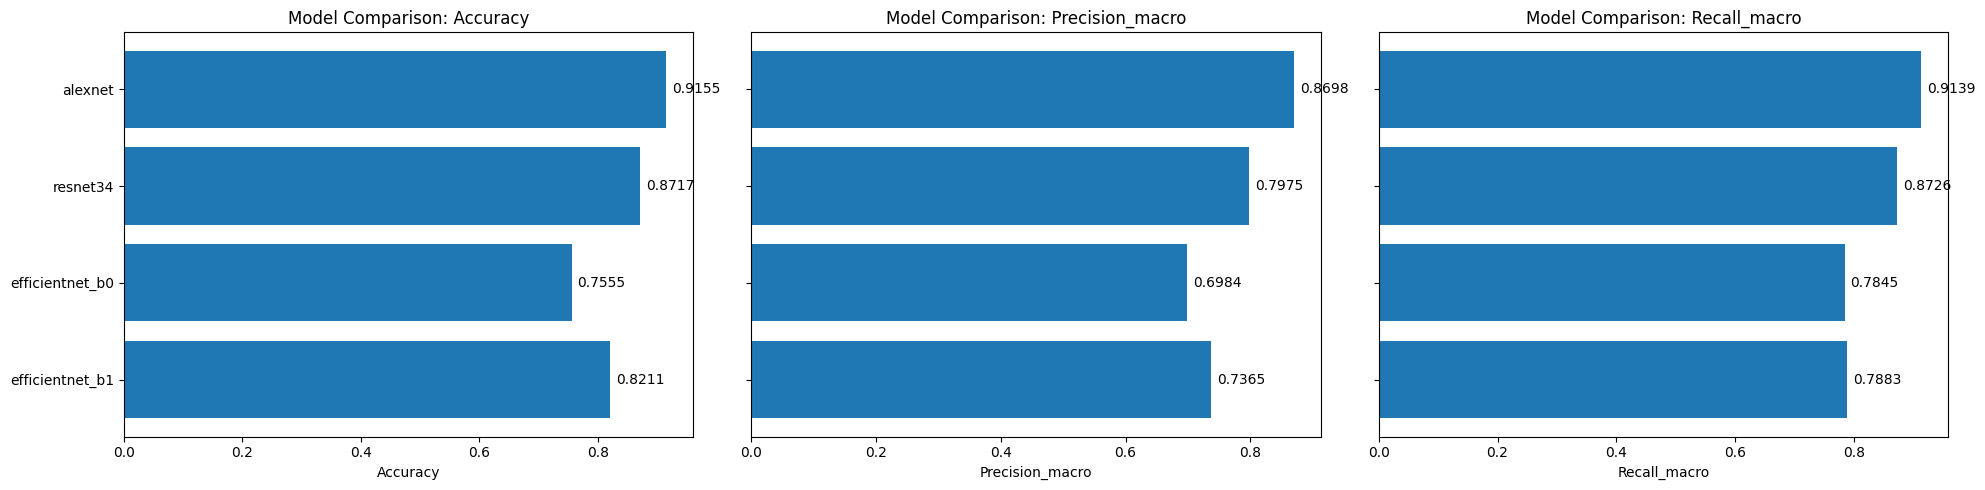

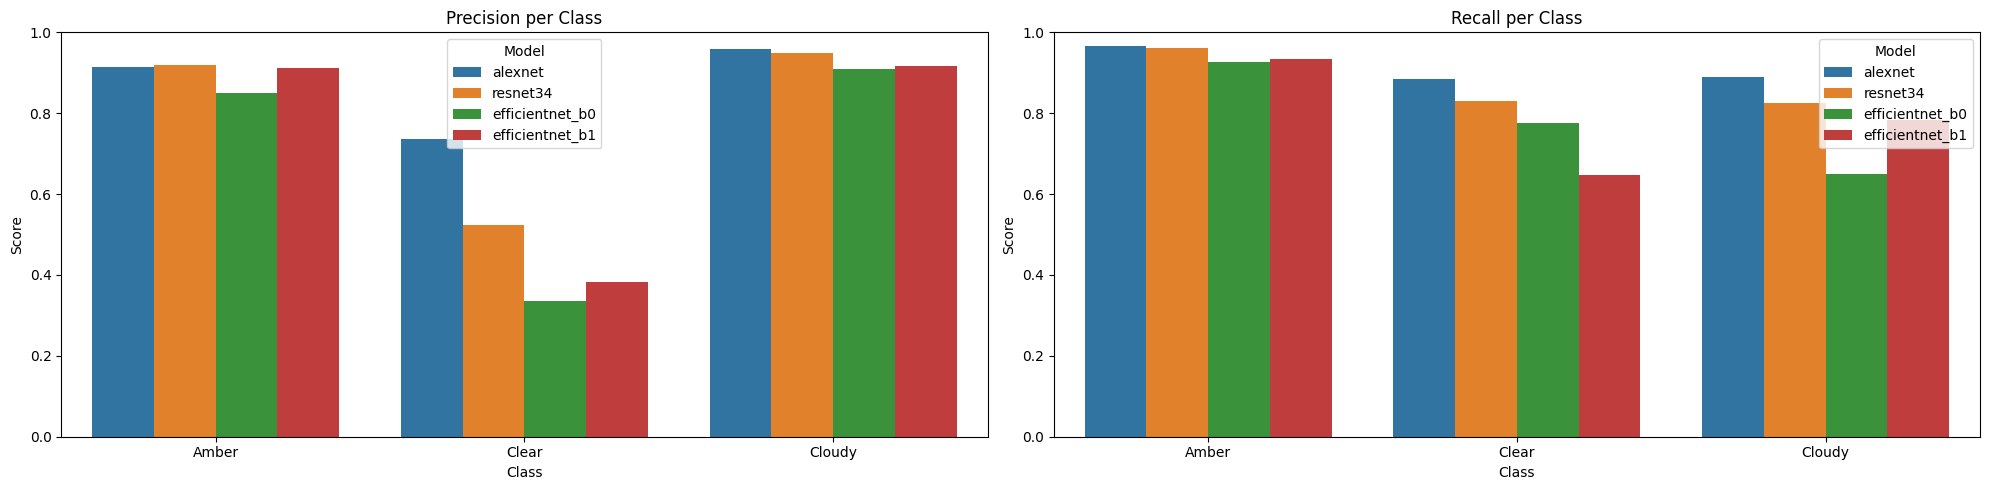

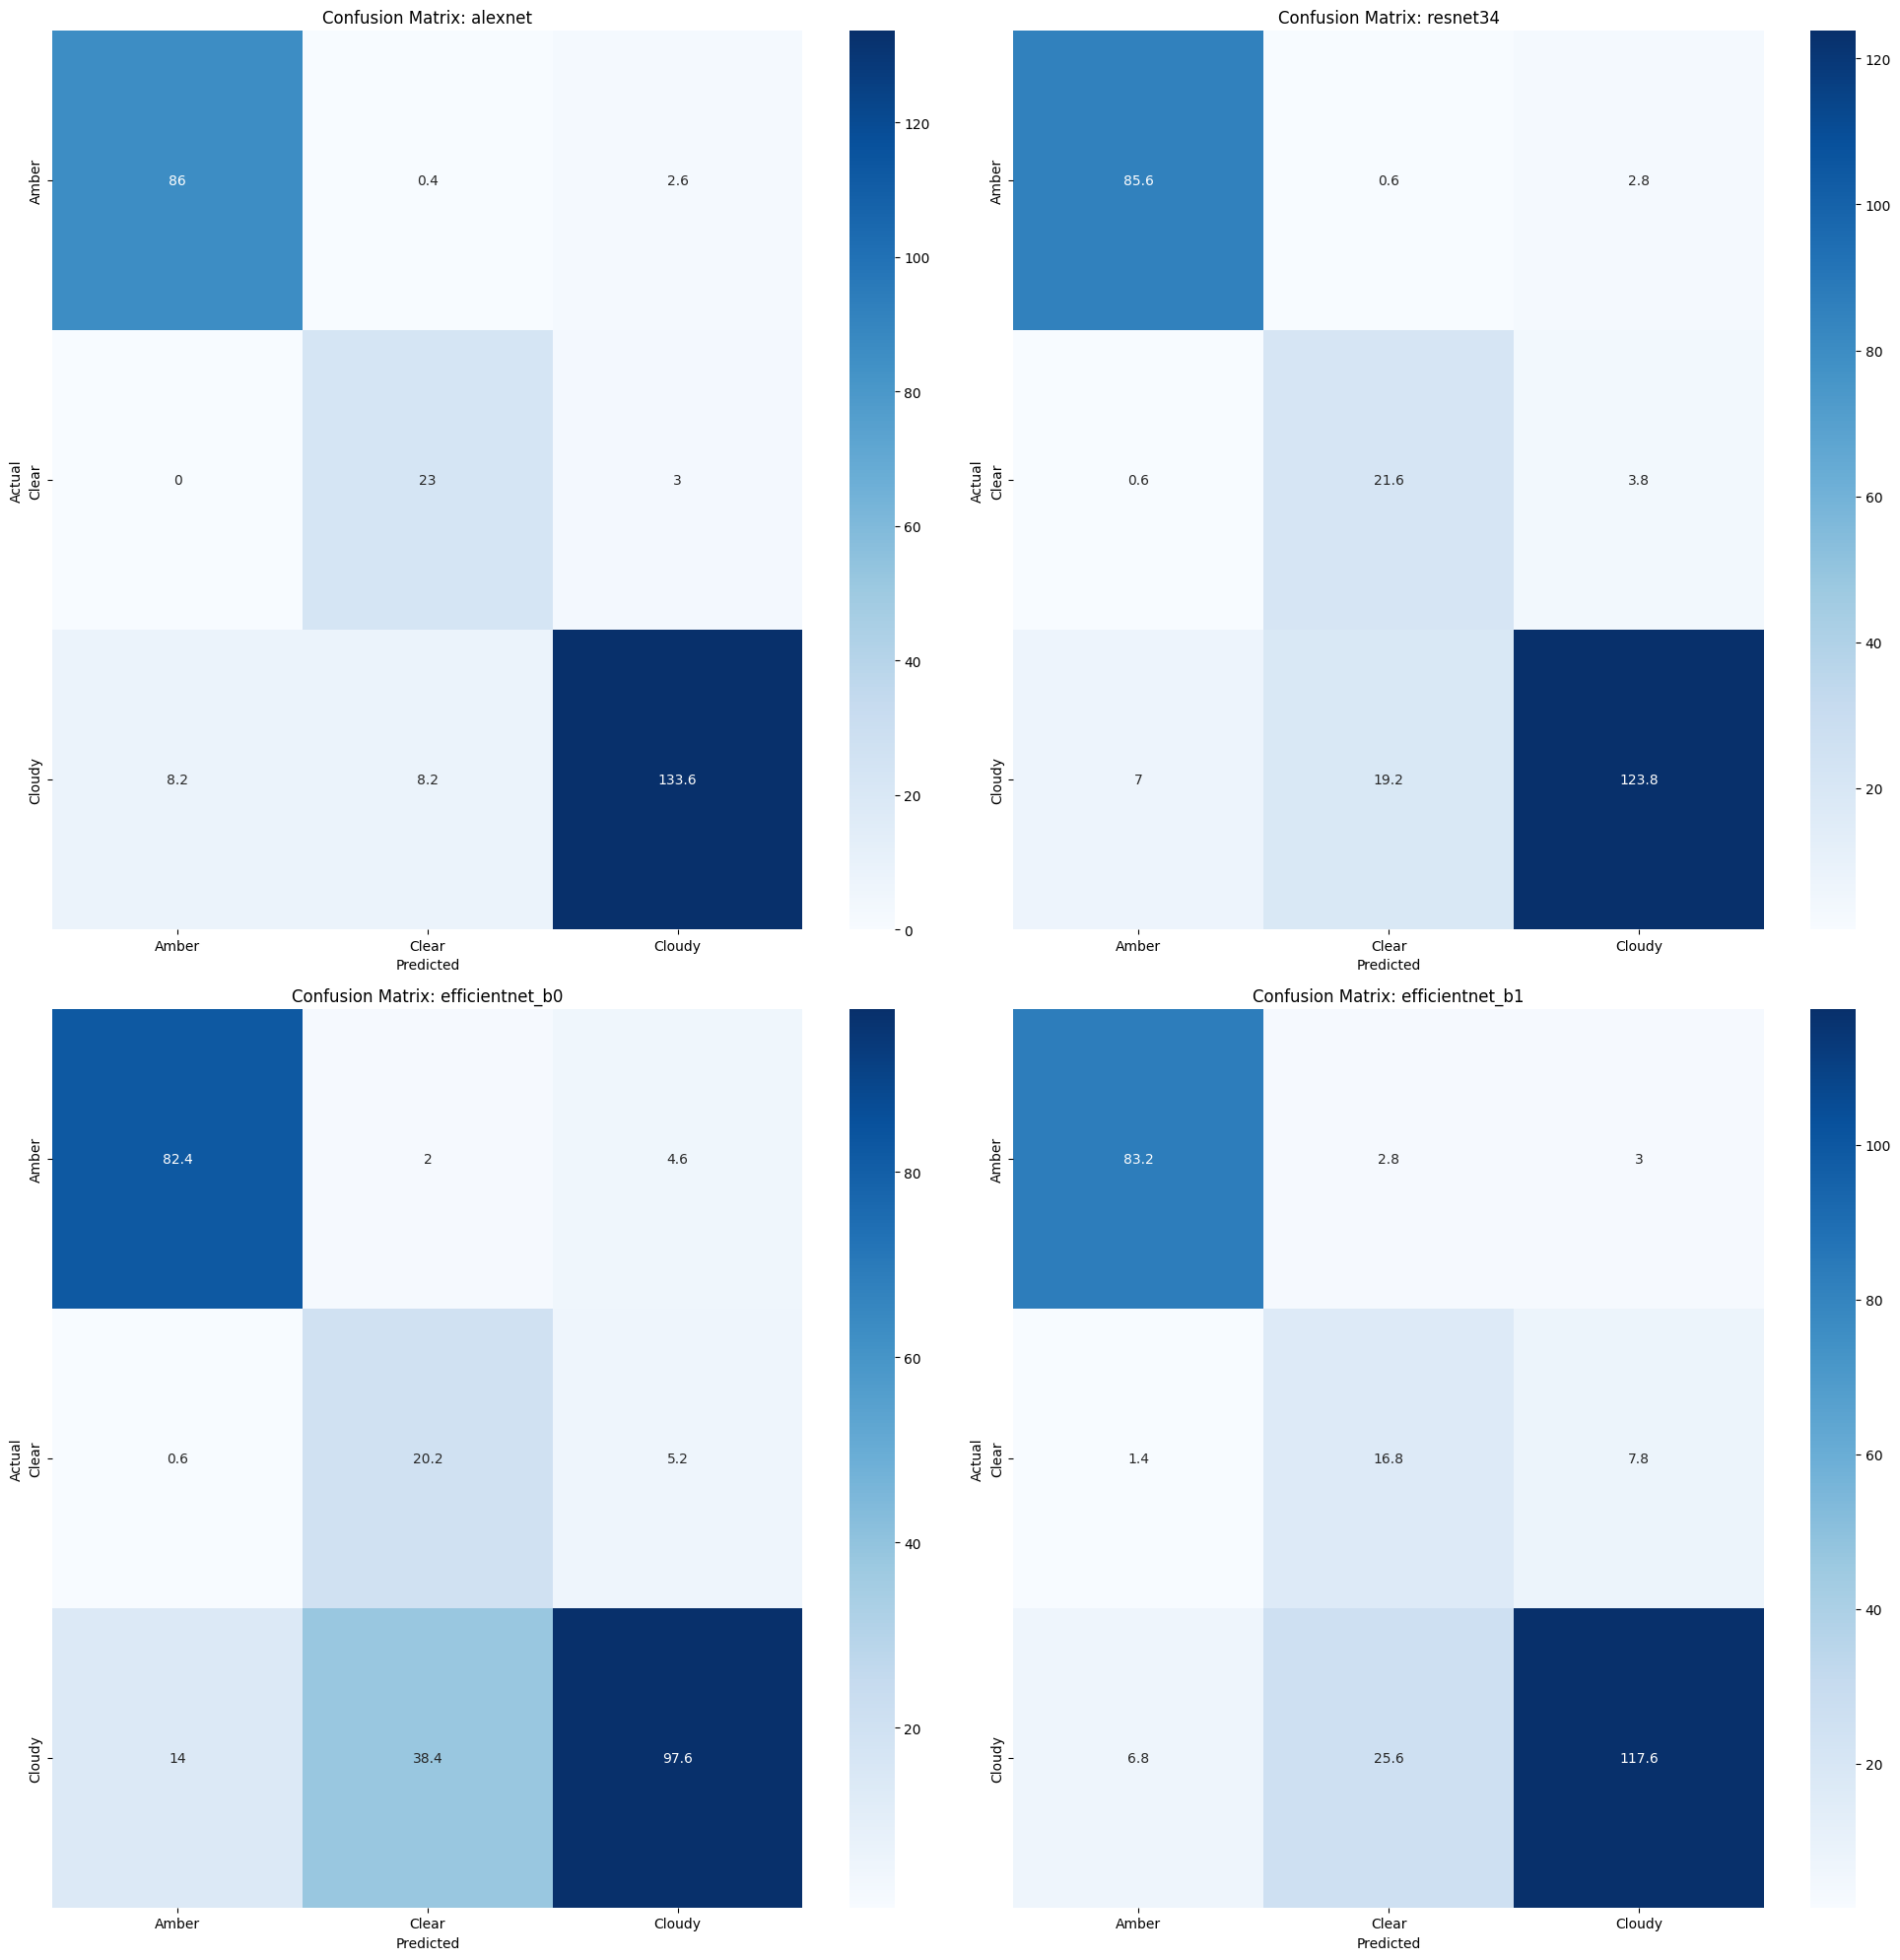

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting metrics for each model
metrics_to_plot = ["accuracy", "precision_macro", "recall_macro"]
num_metrics = len(metrics_to_plot)
fig, axes = plt.subplots(1, num_metrics, figsize=(20, 5), sharey=True)

for i, metric in enumerate(metrics_to_plot):
    metric_values = average_results_df[metric]
    models = average_results_df['model']
    y_pos = np.arange(len(models))

    axes[i].barh(y_pos, metric_values, align='center')
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(models)
    axes[i].invert_yaxis()
    axes[i].set_xlabel(metric.capitalize())
    axes[i].set_title(f'Model Comparison: {metric.capitalize()}')

    for j in range(len(models)):
        axes[i].text(metric_values[j] + 0.01, y_pos[j], f'{metric_values[j]:.4f}', va='center')

plt.tight_layout()
plt.show()

# Plot precision and recall for each class
class_labels = ['Amber', 'Clear', 'Cloudy']

# Prepare precision and recall data for plotting
precision_data = []
recall_data = []
for i, row in average_results_df.iterrows():
    model_name = row['model']
    precision_per_class = row['precision_per_class']
    recall_per_class = row['recall_per_class']
    for j, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
        precision_data.append({'Model': model_name, 'Class': class_labels[j], 'Score': precision})
        recall_data.append({'Model': model_name, 'Class': class_labels[j], 'Score': recall})

precision_df = pd.DataFrame(precision_data)
recall_df = pd.DataFrame(recall_data)

# Plot class-wise precision and recall
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(x='Class', y='Score', hue='Model', data=precision_df, ax=axes[0])
axes[0].set_title('Precision per Class')
axes[0].set_ylim(0, 1)

sns.barplot(x='Class', y='Score', hue='Model', data=recall_df, ax=axes[1])
axes[1].set_title('Recall per Class')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Plot confusion matrices for each model
num_models = len(average_results_df)
num_cols = 2
num_rows = (num_models + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()

for i, (index, row) in enumerate(average_results_df.iterrows()):
    cm = np.array(row['confusion_matrix'])
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=axes[i],
                xticklabels=class_labels, yticklabels=class_labels)
    axes[i].set_title(f'Confusion Matrix: {row["model"]}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
#TODO NEXT
"""
V - try to understand how can i improve the use of the dinov2 (for start it didnt recieve the best results)
V - compare more classifiers on the dinov2
- try more models that convert the images to embeddings and then with classifiers
- try to see if i can apply thresholds based on colors or other features to cluster or classify the trichomes
- try to see if i can apply some kind of clustering to the images and then classify them
- try to see if i can apply some kind of clustering to the embeddings and then classify them.
- check if i can do more transformations like i did in the time series course to the data in order to perform classification.
"""